In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm as cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils import resample
from sklearn.utils.extmath import cartesian

from datetime import datetime
import pickle
import dill
import copy
import io
import os
import shutil
import tarfile

from ipywidgets import widgets
from IPython.display import HTML

#!pip install -U -q tensorflow-gpu
#!pip install -U -q tensorflow-cpu
import tensorflow as tf

#!pip install -U -q pysurvival
from pysurvival.models.semi_parametric import CoxPHModel, NonLinearCoxPHModel
from pysurvival.models.non_parametric import KaplanMeierModel
from pysurvival.models._coxph import _baseline_functions
from pysurvival.utils.display import display_non_parametric, compare_to_actual, display_loss_values, correlation_matrix

#!pip install -U -q lifelines
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.utils import concordance_index

##!pip install -U -q PyDrive
#from pydrive.auth import GoogleAuth
#from pydrive.drive import GoogleDrive
##from google.colab import auth, files
#from oauth2client.client import GoogleCredentials

##Henry
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

/home/buckcenter.org/hhuang/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
df = pd.read_csv('../data/df.csv', index_col=0)

date_cols = [col for col in df.columns if col.startswith('date_')]
df[date_cols] = df[date_cols].apply(pd.to_datetime, format='%Y-%m-%d', axis=0)

df.head()

,date_birth,date_assessment,age_assessment,sex,ethnicity,BMI,smoking_num,diastolic_blood_pressure,systolic_blood_pressure,smoking_cat,...,E_Incidence_CHD,T_Incidence_CHD,E_Incidence_Stroke,T_Incidence_Stroke,E_Incidence_Composite,T_Incidence_Composite,E_Mortality_W-CVD,T_Mortality_W-CVD,E_Incidence_W-CVD,T_Incidence_W-CVD
id,,,,,,,,,,,,,,,,,,,,,
2662726,1962-12-15,2009-12-11,46.990698,Male,Black,23.4924,2.0,82.5,135.5,Current,...,False,7.301998,False,7.301998,False,7.301998,False,8.178128,False,7.301998
2232224,1940-12-15,2009-05-22,68.433986,Male,White,24.8075,0.0,82.5,158.5,Never,...,True,3.466190,False,7.857793,True,3.466190,False,8.733923,False,7.857793
4485128,1961-09-15,2008-09-25,47.029029,Female,White,24.0436,2.0,67.0,94.0,Current,...,False,8.512153,False,8.512153,False,8.512153,False,9.388283,False,8.512153
4326774,1950-07-15,2009-11-12,59.330445,Male,White,22.7583,2.0,68.5,121.5,Current,...,False,7.381397,False,7.381397,False,7.381397,False,8.257528,False,7.381397
3467770,1940-06-15,2008-09-15,68.253284,Female,White,23.6488,0.0,90.0,158.0,Never,...,False,8.539532,False,8.539532,False,8.539532,False,9.415662,False,8.539532


## GLobal Functions

In [4]:
def CI(x, sigma2, C=95):
  dx = stats.norm.ppf((1 + C/100) / 2, loc = 0, scale = 1) * np.sqrt(sigma2)
  return x - dx, x + dx

def c_index_bootstrap(T, E, scores, alpha=0.05, n_bootstrap=10, random_state=None):
  np.random.seed(random_state)

  c_index = concordance_index(T, -scores, E)
  
  stacked_arr = np.stack((T, -scores, E), axis=-1)
  c_idx_boot = np.array([concordance_index(*resample(stacked_arr).T) for _ in range(n_bootstrap)])

  c_index_boot = c_idx_boot.mean()
  sigma2 = c_idx_boot.var()
  CI_lower = np.quantile(c_idx_boot, alpha/2)
  CI_upper = np.quantile(c_idx_boot, 1 - alpha/2)

  return c_index, c_index_boot, sigma2, CI_lower, CI_upper

def c_index_jackknife(T, E, scores, alpha=0.05):

  c_index = concordance_index(T, -scores, E)
  
  stacked_arr = np.stack((T, -scores, E), axis=-1)
  n = stacked_arr.shape[0]
  c_idx_jack = np.array([concordance_index(*np.delete(stacked_arr, i, axis=0).T) for i in range(n)])
  
  c_index_jack = c_idx_jack.mean()
  sigma2 = (n-1) * c_idx_jack.var()
  CI_lower, CI_upper = CI(c_index_jack, sigma2, C=95)

  return c_index, c_index_jack, sigma2, CI_lower, CI_upper
  
def c_diff_bootstrap(T, E, scores1, scores2, alpha=0.05, n_bootstrap=10, random_state=None):

  np.random.seed(random_state)
  c1 = concordance_index(T, -scores1, E)
  c2 = concordance_index(T, -scores2, E)
  dc = c1 - c2

  stacked_arr = np.stack((T, -scores1, -scores2, E), axis=-1)
    
  def c_diff(data):
    sample = resample(data)
    return concordance_index(*sample[:, [0,1,3]].T) - concordance_index(*sample[:, [0,2,3]].T)

  dc_sample = np.array([c_diff(stacked_arr) for _ in range(n_bootstrap)])

  dc_boot = dc_sample.mean()
  sigma2 = dc_sample.var()
  CI_lower = np.quantile(dc_sample, alpha/2)
  CI_upper = np.quantile(dc_sample, 1 - alpha/2)

  return dc, dc_boot, sigma2, CI_lower, CI_upper

## Deepsurv Function

In [5]:
class DeepSurv:

  def __init__(self, structure, input_dim, n_outcomes=1):
    
    self.structure = structure
    self.input_dim = input_dim
    self.n_outcomes = n_outcomes
    self._trained = False

    self._TRAIN_BUF = 500000
    self._TEST_BUF = 50000
    
    self.model = tf.keras.Sequential()
    input_dim = self.input_dim
    
    for layer in self.structure['inner_layers']:
      activ = layer.setdefault('activation', 'relu')
      if activ == 'selu':
        layer['initialization'] = 'lecun_uniform'
      else:
        layer.setdefault('initialization', 'glorot_uniform')
      self.model.add(tf.keras.layers.Dense(layer['num_units'], 
                                           input_shape=(input_dim,),
                                           activation=activ, 
                                           kernel_initializer=layer['initialization'],
                                           kernel_regularizer=tf.keras.regularizers.l2(layer.setdefault('l2_reg', 1e-4))))
      if layer.setdefault('batch_norm', True):
        self.model.add(tf.keras.layers.BatchNormalization())
      if layer['dropout'] > 0:
        do = layer.setdefault('dropout', 0.1)
        self.model.add(tf.keras.layers.AlphaDropout(do) if activ == 'selu' else tf.keras.layers.Dropout(do))
      
      input_dim = layer['num_units']

    self.model.add(tf.keras.layers.Dense(n_outcomes, input_dim=input_dim, activation='linear',
                                         use_bias=self.structure['output_layer'].setdefault('use_bias', True),
                                         kernel_initializer=layer.setdefault('initialization', 'glorot_uniform'),
                                         kernel_regularizer=tf.keras.regularizers.l2(self.structure['output_layer'].setdefault('l2_reg', 1e-4))))

  def is_structure(self, structure):
      if len(self.structure['inner_layers']) != len(structure['inner_layers']):
        return False
      
      for key, value in structure['output_layer'].items():
        if self.structure['output_layer'][key] != value:
          return False
      
      for i, layer in enumerate(structure['inner_layers']):
        for key, value in layer.items():
          if callable(value):
            if not callable(self.structure['inner_layers'][i][key]):
              return False
            if self.structure['inner_layers'][i][key].__code__.co_code != value.__code__.co_code:
              return False
          else:
            if self.structure['inner_layers'][i][key] != value:
              return False
      
      return True

  @staticmethod
  def _c_index(E, T, scores):
    return concordance_index(T, -scores, E)

  @staticmethod
  def _get_ith_col(tensor, i):
    return tf.reshape(tensor[:, i], (-1, 1))

  @staticmethod
  def _compute_loss_single_outcome(scores, risk, fail, Efron_coef, Efron_ones):
    n_fails = tf.reduce_sum(fail)

    numerator = tf.reduce_sum(tf.linalg.matmul(fail, scores))
    
    risk_scores = tf.linalg.matmul(risk, tf.exp(scores))
    fail_scores = tf.linalg.matmul(fail, tf.exp(scores))
    Efron_risk = Efron_ones * risk_scores
    Efron_fail = Efron_coef * fail_scores
    denominator = tf.reduce_sum(tf.math.log(Efron_risk - Efron_fail + (1-Efron_ones)))

    return - (numerator-denominator) / n_fails

  def _get_loss_fn(self):
    def _compute_loss(scores, risk, fail, Efron_coef, Efron_ones):
      loss = 0
      for i in range(self.n_outcomes):
        loss += self._compute_loss_single_outcome(self._get_ith_col(scores, i),
                                                  risk[i], fail[i],
                                                  Efron_coef[i], Efron_ones[i])
      return loss
    return _compute_loss if self.eager else tf.function(_compute_loss)

  def _get_apply_grad_fn(self, loss_fn, optimizer):
    def apply_gradients(X, risk, fail, Efron_coef, Efron_ones):
      with tf.GradientTape() as tape:
        loss = loss_fn(self.model(X, training=True), risk, fail, Efron_coef, Efron_ones)
      gradients = tape.gradient(loss, self.model.trainable_variables)
      optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
      return loss, gradients
    return apply_gradients if self.eager else tf.function(apply_gradients)

  def _get_Efron(self, fail, fixed_hdim=None):
    Efron_coef = ()
    Efron_ones = ()
    for i in range(self.n_outcomes):
      n_fail_per_time = fail[i].sum(axis=1).astype(np.int32)
      h_dim = n_fail_per_time.max() if fixed_hdim is None else fixed_hdim
      if h_dim < n_fail_per_time.max():
        raise ValueError('DeepSurv::_get_Efron: the fixed horizontal direction ({}) is strictly smaller than the maximum number of events per time ({})'.format(h_dim, n_fail_per_time.max()))
      
      Efron_coef += (np.stack([np.pad(np.arange(d)/d, (0, h_dim-d)) for d in n_fail_per_time], axis=0).astype(np.float32),)
      Efron_ones += (np.stack([np.pad(np.ones(d), (0, h_dim-d)) for d in n_fail_per_time], axis=0).astype(np.float32),)
    
    return Efron_coef, Efron_ones
  
  def _get_risk_fail(self, E, T, fixed_vdim=None):
    times = ()
    risk = ()
    fail = ()
    pad = fixed_vdim - len(times) if fixed_vdim is not None else 0
    if pad < 0:
      raise ValueError('DeepSurv::_get_risk_fail: the fixed vertical direction is strictly smaller than the number of times with at least an event')

    for i in range(self.n_outcomes):
      Ei = E[i].numpy()
      Ti = T[i].numpy()
      ti = np.unique(Ti[Ei.astype(np.bool)])
      times += (ti,)
      risk += (np.pad((ti.reshape(-1, 1) <= Ti).astype(np.float32),
                      pad_width=((0, pad), (0, 0))),)
      fail += (np.pad((ti.reshape(-1, 1) == Ti).astype(np.float32) * Ei,
                      pad_width=((0, pad), (0, 0))),)

    return times, risk, fail
  
  def fit(self,
          X_train, E_train, T_train,
          X_test, E_test, T_test,
          optimizer=tf.keras.optimizers.Adam(),
          n_epochs=20, lr=1e-3,
          batch_size=None, batch_n_events=None,
          eager=True, opt_memory=False,
          evaluation_prms={}):
    
    self.eager = eager
    self.opt_config = optimizer.get_config()
    self.opt_config['learning_rate'] = lr
    self.n_epochs = [n_epochs] if not self._trained else self.n_epochs + [n_epochs]
    
    E_train_ = E_train if isinstance(E_train, tuple) else (E_train,)
    T_train_ = T_train if isinstance(T_train, tuple) else (T_train,)
    E_test_ = E_test if isinstance(E_test, tuple) else (E_test,)
    T_test_ = T_test if isinstance(T_test, tuple) else (T_test,)

    if batch_size is not None:
      batch_size_ = batch_size
    elif batch_n_events is not None:
      perc_events = min([E.sum() / E.shape[0] for E in E_train_])
      batch_size_ = int(np.ceil(batch_n_events / perc_events))
      print('Batch size automatically computed as {} samples'.format(batch_size_))
    else:
      batch_size_ = X_train.shape[0]
    
    steps_train_ = X_train.shape[0] // batch_size_
    steps_test_ = X_test.shape[0] // batch_size_

    if not self._trained:
      self.batch_size = []
      self.steps_train = []
      self.steps_test = []
    
    self.batch_size += [batch_size_]
    self.steps_train += [steps_train_]
    self.steps_test += [steps_test_]
    
    print('During training: {} steps per epoch'.format(steps_train_))

    dataset_train = (tf.data.Dataset.from_tensor_slices((X_train.to_numpy().astype(np.float32), E_train_, T_train_))
                     .shuffle(self._TRAIN_BUF, reshuffle_each_iteration=self.eager or not opt_memory)
                     .batch(batch_size_, drop_remainder=True))
    dataset_test = (tf.data.Dataset.from_tensor_slices((X_test.to_numpy().astype(np.float32), E_test_, T_test_))
                    .shuffle(self._TEST_BUF, reshuffle_each_iteration=self.eager or not opt_memory)
                    .batch(batch_size_, drop_remainder=True))
    
    # define apply_gradient functions
    apply_gradients = self._get_apply_grad_fn(self._get_loss_fn(), 
                                              optimizer.from_config(self.opt_config))
    
    if not hasattr(self, 'loss_train'):
      self.loss_train = np.array([])
    if not hasattr(self, 'loss_epoch_train'):
      self.loss_epoch_train = np.array([])
    
    # batch data for (static) matrix sizes
    if self.eager:
      vdim_train = None
      hdim_train = None
    elif opt_memory:
      vdim_train = 0
      hdim_train = 0
      for _, E, T in dataset_train:
        times, _, fail = self._get_risk_fail(E, T)
        for i in range(self.n_outcomes):
          vdim_train = max(vdim_train, len(times[i]))
          hdim_train = max(hdim_train, fail[i].sum(axis=1).astype(np.int32).max())
    else:
      vdim_train = batch_size_
      hdim_train = batch_size_
      
    # initilise evaluation parameters
    evaluation_prms.setdefault('c_train', True)
    evaluation_prms.setdefault('c_test', True)
    evaluation_prms.setdefault('loss_test', True)
    
    if evaluation_prms['c_train'] and not hasattr(self, 'c_train'):
      self.c_train = [[]]*self.n_outcomes
    if evaluation_prms['c_test'] and not hasattr(self, 'c_test'):
      self.c_test = [[]]*self.n_outcomes
    
    if evaluation_prms['loss_test']:
      loss_fn_test = self._get_loss_fn()
      if not hasattr(self, 'loss_test'):
        self.loss_test = np.array([])
      if not hasattr(self, 'loss_epoch_test'):
        self.loss_epoch_test = np.array([])
      
      if self.eager:
        vdim_test = None
        hdim_test = None
      elif opt_memory:
        vdim_test = 0
        hdim_test = 0
        for _, E, T in dataset_test:
          times, _, fail = self._get_risk_fail(E, T)
          for i in range(self.n_outcomes):
            vdim_test = max(vdim_test, len(times[i]))
            hdim_test = max(hdim_test, fail[i].sum(axis=1).astype(np.int32).max())
      else:
        vdim_test = batch_size_
        hdim_test = batch_size_
    
    print('\nTraining...')
    tot_epochs = sum(self.n_epochs)
    for epoch in range(tot_epochs-n_epochs, tot_epochs):
      start_time = datetime.now()
      losses_epoch = np.array([])
      str_epoch = 'Epoch {}/{}:'.format(epoch + 1, tot_epochs)
      print('{} {}'.format(str_epoch, self._load_bar(0, steps_train_)), end='')
      for i, train_batch in enumerate(dataset_train):
        X_batch = train_batch[0]
        E_batch = train_batch[1]
        T_batch = train_batch[2]
        _, risk, fail = self._get_risk_fail(E_batch, T_batch, fixed_vdim=vdim_train)
        Efron_coef, Efron_ones = self._get_Efron(fail, fixed_hdim=hdim_train)
        loss, _ = apply_gradients(X_batch,
                                  risk, fail,
                                  Efron_coef, Efron_ones)
        losses_epoch = np.append(losses_epoch, loss.numpy())
        print('\r{} {} Learning time!'.format(str_epoch, self._load_bar(i+1, steps_train_)), end='')
      
      self.loss_train = np.append(self.loss_train, losses_epoch)
      self.loss_epoch_train = np.append(self.loss_epoch_train, losses_epoch.mean())
      full_bar = self._load_bar(1, 1)
      print('\r{} {}'.format(str_epoch, full_bar), end='')
      
      if evaluation_prms['loss_test']:
        print('\r{} {} Computing loss function on Test Batches...'.format(str_epoch, full_bar), end='')
        losses_epoch = np.array([])
        for test_batch in dataset_test:
          X_batch = test_batch[0]
          E_batch = test_batch[1]
          T_batch = test_batch[2]
          _, risk, fail = self._get_risk_fail(E_batch, T_batch, fixed_vdim=vdim_test)
          Efron_coef, Efron_ones = self._get_Efron(fail, fixed_hdim=hdim_test)
          losses_epoch = np.append(losses_epoch,
                                   loss_fn_test(self.model(X_batch),
                                                risk, fail,
                                                Efron_coef, Efron_ones).numpy())
          
        self.loss_test = np.append(self.loss_test, losses_epoch)
        self.loss_epoch_test = np.append(self.loss_epoch_test, losses_epoch.mean())

      if evaluation_prms['c_train']:
        scores = self.model(X_train.to_numpy().astype(np.float32)).numpy()
        for i in range(self.n_outcomes):
          print('\r{} {} Computing c_index for outcome {} on Train Set...'.format(str_epoch, full_bar, i+1), end='')
          self.c_train[i] = self.c_train[i] + [self._c_index(E_train_[i], T_train_[i], scores[:, i])]
      if evaluation_prms['c_test']:
        scores = self.model(X_test.to_numpy().astype(np.float32)).numpy()
        for i in range(self.n_outcomes):
          print('\r{} {} Computing c_index for outcome {} on Test Set...'.format(str_epoch, full_bar, i+1), end='')
          self.c_test[i] = self.c_test[i] + [self._c_index(E_test_[i], T_test_[i], scores[:, i])]

      info_str = '\r{}'.format(str_epoch)
      if evaluation_prms['c_train']:
        info_str += 'Train set c_index: ('
        for i in range(self.n_outcomes): 
          info_str += '{:.6f} '.format(self.c_train[i][-1])
        info_str += ') -- '
      if evaluation_prms['c_test']:
        info_str += 'Test set c_index: ('
        for i in range(self.n_outcomes): 
          info_str += '{:.6f} '.format(self.c_test[i][-1])
        info_str += ') -- '
      info_str += 'time elapse for current epoch {}'.format(datetime.now() - start_time)
      print(info_str)
      
    print('Computing Baselines (using PySurvival function)...'.format())
    self.times, self.baseline_hazard, self.baseline_survival = self._compute_baseline(X_train, T_train_, E_train_, PySurv=True)

    print('Training finished')
    self._trained = True

    print('\nEvaluation:')
    evaluation_prms.setdefault('n_bootstrap', 10)
    self.evaluate(X_train, E_train_, T_train_,
                  X_test, E_test_, T_test_,
                  prms=evaluation_prms)
    
  def evaluate(self, 
               X_train, E_train, T_train,
               X_test, E_test, T_test, 
               prms):
    
    n_bootstrap = prms.get('n_bootstrap', 100)
    c_train = prms.get('c_train', True)
    c_test = prms.get('c_test', True)
    loss_test = prms.get('loss_test', True)

    # Computation of c-index on Train and Test set with errors
    if c_train or c_test:
      print('Bootstrap computation of c-index with {} bootstraps...'.format(n_bootstrap))
      c_index_names = ['c_index', 'c_index_boot', 'sigma2', 'CI_lower', 'CI_upper']
    if c_train:
      self.c_index_train = ()
      scores = self.predict_risk(X_train)
      for i in range(self.n_outcomes):
        c_index_train = c_index_bootstrap(T_train[i], E_train[i], scores[:, i], n_bootstrap=n_bootstrap)
        self.c_index_train += (dict(zip(c_index_names, c_index_train)),)
        print('c-index (train set, outcome {}) : {:.4f} ({:.4f}) CI({:.4f}, {:.4f})'.format(
            i+1,
            self.c_index_train[i]['c_index'], np.sqrt(self.c_index_train[i]['sigma2']), 
            self.c_index_train[i]['CI_lower'], self.c_index_train[i]['CI_upper']))
    if c_test:
      self.c_index_test = ()
      scores = self.predict_risk(X_test)
      for i in range(self.n_outcomes):
        c_index_test = c_index_bootstrap(T_test[i], E_test[i], scores[:, i], n_bootstrap=n_bootstrap)
        self.c_index_test += (dict(zip(c_index_names, c_index_test)),)
        print('c-index (test set, outcome {}) : {:.4f} ({:.4f}) CI({:.4f}, {:.4f})'.format(
            i+1,
            self.c_index_test[i]['c_index'], np.sqrt(self.c_index_test[i]['sigma2']), 
            self.c_index_test[i]['CI_lower'], self.c_index_test[i]['CI_upper']))

    # Plot of Loss on Train and Test set
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))

    x_train = np.array([])
    x_test = np.array([])
    tot_epochs = sum(self.n_epochs)
    for i, e in enumerate(self.n_epochs):
      x_train = np.append(x_train, np.sum(self.n_epochs[:i]) + (np.arange(self.n_epochs[i]*self.steps_train[i])+1)/self.steps_train[i])
      x_test = np.append(x_test, np.sum(self.n_epochs[:i]) + (np.arange(self.n_epochs[i]*self.steps_test[i])+1)/self.steps_test[i])
    
    for x in np.cumsum(self.n_epochs[:-1]):
      ax.axvline(x, ymin=0, ymax=1, color='orange', alpha=0.8, lw=1.5, ls=':')
    ax.plot(x_train, self.loss_train, color='blue', alpha=0.3, lw=1, label='Loss Values on Train Batch')
    if loss_test and hasattr(self, 'loss_test'):
      ax.plot(x_test, self.loss_test, color='red', alpha=0.3, lw=2, label='Loss values on Test Batch')
    ax.plot(np.arange(tot_epochs)+1, self.loss_epoch_train,
            color='blue', alpha=1, lw=3, label='Average Loss Value of Train Batch during Epoch')
    if loss_test and hasattr(self, 'loss_test'):
      ax.plot(np.arange(tot_epochs)+1, self.loss_epoch_test,
              color='red', alpha=1, lw=3, label='Average Loss Value of Test Batch during Epoch')
    ax.set_xlabel('Number of eopochs', fontsize=12)
    ax.legend(fontsize=12)
    ax.set_title('Loss function values', fontsize=14)
    fig.show()

    # Plots of c-index on Train and Test set
    fig, axs = plt.subplots(nrows=1, ncols=self.n_outcomes, figsize=(10*self.n_outcomes, 8))
    for i, ax in enumerate(np.array(axs).reshape(-1)):
      for x in np.cumsum(self.n_epochs[:-1]):
        ax.axvline(x, ymin=0, ymax=1, color='orange', alpha=0.8, lw=1.5, ls=':')
      if c_train and hasattr(self, 'c_train'):
        ax.plot(np.arange(tot_epochs)+1, self.c_train[i], color='blue', label='c-index on Train set')
      if c_test and hasattr(self, 'c_test'):
        ax.plot(np.arange(tot_epochs)+1, self.c_test[i], color='red', label='c-index on Test set')
      ax.set_xlabel('Number of epochs', fontsize=12)
      ax.legend(fontsize=12)
      ax.set_title('C-index for outcome {}'.format(i+1), fontsize=14)
    fig.show()
    
    # Plots of Survival Curves with Kaplan-Meier
    if prms.get('check_KM', True):
      self.check_KM(X_test, E_test, T_test)

    return
  
  def _compute_baseline(self, X, T, E, PySurv=True):
    scores = self.predict_risk(X)
    times = ()
    baseline_hazard = ()
    baseline_survival = ()
    if PySurv:
      for i in range(self.n_outcomes):
        desc_order = np.argsort(-T[i])
        baselines = _baseline_functions(scores[:, i][desc_order],
                                        T[i][desc_order], E[i][desc_order])
        times += (np.array(baselines[0]),)
        baseline_hazard += (np.array(baselines[1]),)
        baseline_survival += (np.array(baselines[2]),)
    else:
      times, risk, fail = self._get_risk_fail(E, T)
      for i in range(self.n_outcomes):
        risk_scores = np.dot(risk[i], scores[:, i])
        baseline_hazard += (fail[i].sum(axis=1) / risk_scores,)
        baseline_survival = (np.exp(-np.cumsum(baseline_hazard)),)
    
    return times, baseline_hazard, baseline_survival
  
  def predict_risk(self, X):
    if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
      Xp = X.to_numpy()
    else:
      Xp = X
    return np.exp(self.model(Xp.astype(np.float32)).numpy())
    
  def predict_hazard_survival(self, X, t=None, outcomes=None):
    scores = self.predict_risk(X)
    times = ()
    h_t = ()
    S_t = ()

    out = range(self.n_outcomes) if outcomes is None else outcomes
    for i in out:
      times += (self.times[i],)
      if t is not None:
        time_bin = np.digitize(t, self.times[i])
        h_t += (self.baseline_hazard[i][time_bin] * scores[:, i],)
        S_t += (np.power(self.baseline_survival[i][time_bin], scores[:, i]),)
      else:
        h_t += (self.baseline_hazard[i] * scores[:, i].reshape(-1, 1),)
        S_t += (np.power(self.baseline_survival[i], scores[:, i].reshape(-1, 1)),)

    return times, h_t, S_t

  def survival_curve(self, X):
    times, _, S_t = self.predict_hazard_survival(X)
    return times, tuple(S_t_i.mean(axis=0) for S_t_i in S_t)

  @staticmethod
  def _KaplanMeier(E, T, alpha=0.95, method='PySurv'):
    if method == 'PySurv':
      km = KaplanMeierModel()
      km.fit(T, E, alpha=alpha)
      return km.times, km.survival, km.survival_ci_lower, km.survival_ci_upper
    elif method == 'Lifelines':
      km = KaplanMeierFitter(alpha=1-alpha)
      km.fit(T, E)
      CI = km.confidence_interval_['KM_estimate_lower_{}'.format(alpha)].to_numpy(), km.confidence_interval_['KM_estimate_upper_{}'.format(alpha)].to_numpy()
      return (km.timeline, km.survival_function_.to_numpy().flatten()) + CI
    else:
      times = np.unique(T[E])
      risk = (times.reshape(-1, 1) <= T).astype(np.float64)
      fail = (times.reshape(-1, 1) == T).astype(np.float64) * E
      log_s = np.log(1. - fail.sum(axis=1)/risk.sum(axis=1))
      S = np.exp(np.cumsum(log_s))
      return times, S

  def check_KM(self, X, E, T):
    fig, axs = plt.subplots(nrows=1, ncols=self.n_outcomes, figsize=(10*self.n_outcomes, 8))  
    
    print('Computing Survival Curves...')
    times, S_t = self.survival_curve(X)
    
    print('Computing Kaplan_Meier Curves with PySurvival routine', end=' ')
    for i, ax in enumerate(np.array(axs).reshape(-1)):
      km_times, km_survival, km_lower, km_upper = self._KaplanMeier(E[i], T[i], method='PySurv')
      ax.plot(km_times, km_survival, color='red', lw=2, label='Kaplan-Meier')
      ax.fill_between(km_times, km_lower, km_upper,
                      facecolor='red', alpha=0.3)
      ax.plot(times[i], S_t[i], color='blue', lw=2, label='DeepSurv')
      ax.tick_params(axis='both', which='major', labelsize=12)
      ax.set_xlabel('time (years)', fontsize=12)
      ax.set_title('Kaplan-Meier vs DeepSurv (Survival Curve) for outcome {}'.format(i+1), fontsize=14)
      ax.legend(fontsize=12)

    fig.show()

  @staticmethod
  def _load_bar(n, N):
    return '[{}{}]'.format('='*int(np.floor(20*n/N)), ' '*int(np.ceil(20*(1-n/N))))

## RISKSCORE class

In [6]:
class RiskScore:
  
  def __init__(self, df,
               event_type='Incidence', disease='Composite',
               #features=model_feat,
               #log_features=log_feat, NA_features=NA_feat, cat_features=cat_feat,
               features=[],
               log_features=[], NA_features=[], cat_features=[],
               secondary_outcomes=[{'event_type': 'Incidence', 'disease': 'Cancer'},
                                   {'event_type': 'Mortality', 'disease': 'All'}],
               test_size=0.1, data_split_random_state=None,
               verb=1):
    
    #import pdb; pdb.set_trace()

    self.event_type = event_type
    self.disease = disease
    self.secondary_outcomes = secondary_outcomes
    
    Ecol = 'E_{}_{}'.format(self.event_type, self.disease)
    Tcol = 'T_{}_{}'.format(self.event_type, self.disease)

    Ecol_II = tuple('E_{}_{}'.format(outcome['event_type'], outcome['disease']) for outcome in self.secondary_outcomes)
    Tcol_II = tuple('T_{}_{}'.format(outcome['event_type'], outcome['disease']) for outcome in self.secondary_outcomes)

    self.feat = features
    self.log_feat = [f for f in self.feat if f in log_features]
    self.NA_feat = [f for f in self.feat if f in NA_features]
    self.cat_feat = [f for f in self.feat if f in cat_features]
    rename_col_f = lambda col: 'log_' + col if col in self.log_feat else col
    
    # Train Test set
    index_train, index_test = train_test_split(df.index, test_size=test_size, random_state=data_split_random_state)
    self.X_train = self.preprocess_data(df.loc[index_train], dummies='fit_transform', scale='fit_transform', na_replace='fit_transform')
    self.X_test = self.preprocess_data(df.loc[index_test], dummies='transform', scale='transform', na_replace='transform')
    self.feat_X = self.X_train.columns

    ## Get E, T
    self.E_train = df.loc[self.X_train.index, Ecol].values
    self.T_train = df.loc[self.X_train.index, Tcol].values
    self.E_test = df.loc[self.X_test.index, Ecol].values
    self.T_test = df.loc[self.X_test.index, Tcol].values

    self.E_train_II = tuple(df.loc[self.X_train.index, E_II].values for E_II in Ecol_II)
    self.T_train_II = tuple(df.loc[self.X_train.index, T_II].values for T_II in Tcol_II)
    self.E_test_II = tuple(df.loc[self.X_test.index, E_II].values for E_II in Ecol_II)
    self.T_test_II = tuple(df.loc[self.X_test.index, T_II].values for T_II in Tcol_II)

    # Age bins
    n_groups_age = 10
    self.df_age_group, self.age_bins = pd.qcut(df.loc[:, 'age_assessment'], n_groups_age, labels=False, retbins=True)
    self.df_age_group.rename('age_group', inplace=True)
    
    # # Baseline Populations
    # baseline_vars = ['sex', 'ethnicity', 'baseline_CVD', 'baseline_Cancer', 'baseline_Hypertension', 'baseline_Diabetes', 'med_cholesterol']
    # unique_values = tuple(df[var].dropna().unique() for var in baseline_vars)
    # all_combn = pd.core.reshape.util.cartesian_product(unique_values)
    # self.df_baseline_pop = (pd.DataFrame({baseline_vars[i]: arr for i, arr in enumerate(all_combn)})
    #                         .assign(pop_group=np.arange(len(all_combn[0]))))
    # self.df_pop_group = (df.merge(self.df_baseline_pop, how='left', on=baseline_vars)
    #                        .set_index(df.index)
    #                        .loc[:, 'pop_group'])
    
    # Print information
    if verb > 0:
      print('Event type : {}, Disease : {}'.format(self.event_type, self.disease))
      print('Features used in fit (CoxPH, DeepSurv) : {}'.format(self.feat_X.tolist()))
      print('* Train set:'.format())
      print('  - length : {}'.format(self.X_train.shape[0]))
      print('  - num. events : {}'.format(self.E_train.sum()))
      print('* Test set:'.format())
      print('  - length : {}'.format(self.X_test.shape[0]))
      print('  - num. events : {}'.format(self.E_test.sum()))
      
    return

  def preprocess_data(self, df, dummies='transform', scale='transform', na_replace='transform'):
    X = df.loc[:, self.feat]

    # Log-transformations
    X.loc[:, self.log_feat] = np.log(X.loc[:, self.log_feat])
    
    # NAs
    #from IPython.core.debugger import set_trace; set_trace()
    
        #### multiple imputations ###
    if na_replace is 'fit_transform':
        na_replace = IterativeImputer(max_iter=10, random_state=0, verbose = 2)
        #na_replace = IterativeImputer(max_iter=1, random_state=0, verbose = 2)
        #na_replace.fit(X[self.NA_feat])
        #na_replace.fit(X)
        #na_replace.fit(X.columns.difference(cat_feat))
        na_replace.fit(X[X.columns[~X.columns.isin(cat_feat)]])
        self.na_replace = na_replace
    elif na_replace is 'transform':
        na_replace = self.na_replace
    
    if na_replace is not None:
      NA_cols = pd.DataFrame([])
      for feat in self.NA_feat:
        NAcol = '{}_NA'.format(feat)
        NA_cols[NAcol] = X[feat].isna()

        #X[NAcol] = X[feat].isna()
      #X[self.NA_feat] = na_replace.transform(X[self.NA_feat])
      #X_trans = na_replace.transform(X)
      #X.loc[:,:] = X_trans
    
      X[X.columns[~X.columns.isin(cat_feat)]] = na_replace.transform(X[X.columns[~X.columns.isin(cat_feat)]])

      #import pdb; pdb.set_trace()
      X = pd.concat([X, NA_cols], axis=1)

    #### multiple imputations ###
    
#     if na_replace is 'fit_transform':
#       na_replace = X[self.NA_feat].mean(axis=0, skipna=True)
#       self.na_replace = na_replace
#     elif na_replace is 'transform':
#       na_replace = self.na_replace
    
#     if na_replace is not None:
#       for feat in self.NA_feat:
#         NAcol = '{}_NA'.format(feat)
#         X[NAcol] = X[feat].isna()
#         X[feat].mask(X[NAcol], other=na_replace[feat], inplace=True)
      
    #import pdb; pdb.set_trace()
    X.dropna(axis=0, inplace=True)
    X.rename(columns=lambda col: 'log_' + col if col in self.log_feat else col, inplace=True)
        
    # Dummies
    if dummies == 'fit_transform':
      #import pdb; pdb.set_trace()
      self.dummy_encoder = OneHotEncoder(categories='auto', drop='first')
      self.dummy_encoder.fit(X[self.cat_feat])
    if dummies in ['transform', 'fit_transform']:
      dummy_colnames = ['{}_{}'.format(feat, val) for i, feat in enumerate(self.cat_feat) for j, val in enumerate(self.dummy_encoder.categories_[i]) if j != self.dummy_encoder.drop_idx_[i]]
      X_dummy = pd.DataFrame(self.dummy_encoder.transform(X[self.cat_feat]).toarray(), index=X.index, columns=dummy_colnames)
      X = X.assign(**X_dummy)
      X.drop(columns=self.cat_feat, inplace=True)

    # Scale
    if scale == 'fit_transform':
      self.scaler = StandardScaler(copy=False, with_mean=True, with_std=True)
      X[X.columns] = self.scaler.fit_transform(X)
    elif scale == 'transform':
      X[X.columns] = self.scaler.transform(X)
    

    
    return X

  def get_age_label(self, age):
    if age < self.age_bins[0] or age >= self.age_bins[-1]:
      return None
    return np.digitize(age, self.age_bins)

  def get_age_group(self, age):
    return self.df_age_group[self.df_age_group == self.get_age_label(age)].index
  
  def density(self, x, n_neigh=10):
    return np.sqrt(self.X_train.shape[1]) / np.sort(np.linalg.norm(self.X_train-x, axis=1))[:n_neigh].mean()

  def CoxPH(self, verb=1, check_assumptions=False, c_index_CI=None, **kwargs):
    dataset = self.X_train.assign(T=self.T_train, E=self.E_train)
    
    if not hasattr(self, 'coxph'):
      coxph = CoxPHFitter()
      coxph.fit(dataset, duration_col='T', event_col='E', show_progress=(verb>0), **kwargs)
    else:
      coxph = self.coxph['model']
    
    if c_index_CI in ['Bootstrap', 'Jackknife']:
      print('{} computation of c-index on train and test set...'.format(c_index_CI))
      c_index_func = c_index_bootstrap if c_index_CI == 'Bootstrap' else c_index_jackknife
      c_index_train, c_train_sample, c_train_sigma2, c_train_lower, c_train_upper = c_index_func(self.T_train, self.E_train, coxph.predict_partial_hazard(self.X_train).values.flatten())
      c_index_test, c_test_sample, c_test_sigma2, c_test_lower, c_test_upper = c_index_func(self.T_test, self.E_test, coxph.predict_partial_hazard(self.X_test).values.flatten())
      c_index_string = ('C-index (train) : {:.4f} ({:.4f}) CI({:.4f}, {:.4f})\n'
                        'C-index (test)  : {:.4f} ({:.4f}) CI({:.4f}, {:.4f})'.format(c_index_train, np.sqrt(c_train_sigma2), c_train_lower, c_train_upper,
                                                                                      c_index_test, np.sqrt(c_test_sigma2), c_test_lower, c_test_upper))
    else:
      c_index_train = concordance_index(self.T_train, -coxph.predict_partial_hazard(self.X_train), self.E_train)
      c_index_test = concordance_index(self.T_test, -coxph.predict_partial_hazard(self.X_test).values.flatten(), self.E_test)
      c_index_string = 'C-index (train) : {:.4f}\nC-index (test)  : {:.4f}'.format(c_index_train, c_index_test)

    if verb > 0:
      coxph.print_summary()
      print('')
      print(c_index_string)
      print('')
      coxph.plot()
    
    if check_assumptions:
      coxph.check_assumptions(dataset, advice=True, show_plots=True, p_value_threshold=0.005)

    self.coxph = {'model': coxph,
                  'c_index_train': c_index_train, 'c_index_test': c_index_test}
    
    if c_index_CI in ['Bootstrap', 'Jackknife']:
      self.coxph['c_train_var'] = c_train_sigma2
      self.coxph['c_train_lower'] = c_train_lower
      self.coxph['c_train_upper'] = c_train_upper
      self.coxph['c_test_var'] = c_test_sigma2
      self.coxph['c_test_lower'] = c_test_lower
      self.coxph['c_test_upper'] = c_test_upper

    return

  def DeepSurv(self, structure, resume_training=True, **kwargs):
    # Check if can continue training or need to start from scratch
    start_from_scratch = False
    if not (hasattr(self, 'deep_surv') and resume_training):
      start_from_scratch = True
    elif not self.deep_surv.is_structure(structure):
      start_from_scratch = True

    # Initialize the model (if requested) and fit
    if start_from_scratch:
      print('Fitting new DeepSurv model...')
      self.deep_surv = DeepSurv(structure=structure, 
                                input_dim=len(self.feat_X), 
                                n_outcomes=1+len(self.secondary_outcomes))
    else:
      print('Continuing fit of pre-existing model...')

    E_train = (self.E_train,) + self.E_train_II
    T_train = (self.T_train,) + self.T_train_II
    E_test = (self.E_test,) + self.E_test_II
    T_test = (self.T_test,) + self.T_test_II
    
    self.deep_surv.fit(self.X_train, E_train, T_train,
                       self.X_test, E_test, T_test,
                       **kwargs)
    
    # Compute the average risk on Train Set
    # def compute_mean_risk(bg):
    #   indices_bg = np.intersect1d(self.X_train.index,
    #                               self.df_pop_group[self.df_pop_group == bg].index)
    #   return self.deep_surv.predict_risk(self.X_train.loc[indices_bg]).mean(axis=0)
    
    # self.df_baseline_pop['mean_risk'] = self.df_baseline_pop['pop_group'].apply(compute_mean_risk)
    self.mean_risk = self.deep_surv.predict_risk(self.X_train).mean(axis=0)

    return

  def compute_RiskScore(self, df, outcomes=None, compute_d=False, preprocess_data=True):
    X = self.preprocess_data(df) if preprocess_data else df
    risk_score = self.deep_surv.predict_risk(X) / self.mean_risk
    if outcomes is not None:
      risk_score = risk_score[:, outcomes]
    
    if compute_d:
      d = X.apply(self.density, n_neigh=10, axis=1).to_numpy()
      return risk_score, d

    return risk_score

  def save(self, filename='RS', folder='.'):
    if hasattr(self, 'deep_surv'):
      folder_model = '{}/{}_DeepSurv_model'.format(folder, filename)
      self.deep_surv.model.save(folder_model,
                                overwrite=True, include_optimizer=True,
                                save_format='tf')
      self.deep_surv.model = None
      
    pkl_filename = '{}/{}.pkl'.format(folder, filename)
    with open(pkl_filename, 'wb') as pkl_file:
      dill.dump(self, pkl_file)
      print('Dumped file: {}'.format(pkl_filename))
    
    if hasattr(self, 'deep_surv'):
      self.deep_surv.model = tf.keras.models.load_model(folder_model)
      
    with tarfile.open('{}/{}.tar.gz'.format(folder, filename), mode='w:gz') as tar_archive:
      tar_archive.add(pkl_filename)
      os.remove(pkl_filename)
      if hasattr(self, 'deep_surv'):
        tar_archive.add(folder_model)
        shutil.rmtree(folder_model)
    
    print('Successfully saved. The .tar.gz archive can now be downloaded from the file menu on the left.')

  @classmethod
  def load(cls):
    print('Please upload the .tar.gz file:')
    uploaded = files.upload()
    archive_name = list(uploaded.keys())[0]
    while not tarfile.is_tarfile(archive_name):
      print('Uploaded file is not a .tar archive. Please upload the .tar.gz file:')
      uploaded = files.upload()
      archive_name = list(uploaded.keys())[0]
    
    filename = archive_name[:-7]
    with tarfile.open('./{}'.format(archive_name), mode='r') as tar_archive:
      tar_archive.extractall()
    os.remove(archive_name)
    
    pkl_filename = './{}.pkl'.format(filename)
    with open(pkl_filename, 'rb') as pkl_file:
      RS_load = dill.load(pkl_file)
      print('Successfully loaded file: {}'.format(pkl_filename))
      os.remove(pkl_filename)
    
    if hasattr(RS_load, 'deep_surv'):
      folder_model = './{}_DeepSurv_model'.format(filename)
      RS_load.deep_surv.model = tf.keras.models.load_model(folder_model)
      print('Successfully uploaded DeepSurv model from folder: {}'.format(folder_model))
      shutil.rmtree(folder_model)
      
    return RS_load


def RiskScoreDashboard(RS, patient_data=None):
  if not hasattr(RS, 'deep_surv'):
    print('No DeepSurv model has been fitted yet. Please use the DeepSurv() function to fit a Neural Network.')
    return
  
  display(HTML('<font size="5">Risk Score Dashboard:</font><br><br>'))
  display(HTML('<font size="4">Please input all the patient data:</font><br><br>'))
    
  age_input = widgets.FloatText(value=patient_data['age_assessment'] if patient_data is not None else None,
                                description='Age: ')
  sex_input = widgets.RadioButtons(value=patient_data['sex'] if patient_data is not None else None,
                                   options=['Male', 'Female'],
                                   description='Sex: ')
  ethnicity_default = patient_data['ethnicity'] if patient_data is not None else None
  if ethnicity_default == 'SouthAsian':
    ethnicity_default = 'South Asian' 
  ethnicity_input = widgets.RadioButtons(value=ethnicity_default,
                                         options=['White', 'Black', 'South Asian', 'Other'],
                                         description='Ethnicity: ')
  
  CVD_input = widgets.Checkbox(value=bool(int(patient_data['baseline_CVD'])) if patient_data is not None else None,
                               description='Diagnosed CVD', 
                               style={'description_width': 'initial'})
  cancer_input = widgets.Checkbox(value=bool(int(patient_data['baseline_Cancer'])) if patient_data is not None else None,
                                  description='Diagnosed cancer', 
                                  style={'description_width': 'initial'})
  hypertension_input = widgets.Checkbox(value=bool(int(patient_data['baseline_Hypertension'])) if patient_data is not None else None,
                                        description='Diagnosed hypertension', 
                                        style={'description_width': 'initial'})
  diabetes_input = widgets.Checkbox(value=bool(int(patient_data['baseline_Diabetes'])) if patient_data is not None else None,
                                    description='Diagnosed diabetes', 
                                    style={'description_width': 'initial'})
  med_cholesterol_input = widgets.Checkbox(value=bool(int(patient_data['med_cholesterol'])) if patient_data is not None else None,
                                           description='Actually on statins', 
                                           style={'description_width': 'initial'})

  smoking_values = ['Never', 'Former', 'Current']
  smoking_default = smoking_values[int(patient_data['smoking_num'])] if patient_data is not None else None
  smoking_input = widgets.RadioButtons(value=smoking_default,
                                       options=smoking_values,
                                       description='Smoking status: ', 
                                       style={'description_width': 'initial'})
  alcohol_values = ['Never', 'Special occasions only', 'One to three times a month', 'Once or twice a week', 'Three or four times a week', 'Daily or almost daily']
  alcohol_default = alcohol_values[int(patient_data['alcohol_num'])] if patient_data is not None else None
  alcohol_input = widgets.RadioButtons(value=alcohol_default,
                                       options=alcohol_values,
                                       description='Alcohol consumed: ', 
                                       style={'description_width': 'initial'})
  diet_values = ['Ideal', 'Poor']
  diet_default = diet_values[int((patient_data['diet_HI']-1)/2)] if patient_data is not None else None
  diet_input = widgets.RadioButtons(value=diet_default,
                                    options=diet_values,
                                    description='Diet: ', 
                                    style={'description_width': 'initial'})
  moderate_activity_input = widgets.FloatText(value=patient_data['moderate_activity'] if patient_data is not None else None,
                                              description='Moderate Physical activity (mins/week): ', 
                                              style={'description_width': 'initial'})
  vigorous_activity_input = widgets.FloatText(value=patient_data['vigorous_activity'] if patient_data is not None else None,
                                              description='Vigorous Physical activity (mins/week): ', 
                                              style={'description_width': 'initial'})
  BMI_input = widgets.FloatText(value=patient_data['BMI'] if patient_data is not None else None,
                                description='BMI (kg/m2): ', 
                                style={'description_width': 'initial'})
  diastolic_blood_pressure_input = widgets.FloatText(value=patient_data['diastolic_blood_pressure'] if patient_data is not None else None,
                                                     description='Diastolic Blood Pressure (mmHg): ', 
                                                     style={'description_width': 'initial'})
  systolic_blood_pressure_input = widgets.FloatText(value=patient_data['systolic_blood_pressure'] if patient_data is not None else None,
                                                    description='Systolic Blood Pressure (mmHg): ', 
                                                    style={'description_width': 'initial'})
  
  cholesterol_input = widgets.FloatText(value=patient_data['cholesterol'] if patient_data is not None else None,
                                        description='Cholesterol (mmol/L): ', 
                                        style={'description_width': 'initial'})
  LDL_input = widgets.FloatText(value=patient_data['LDL'] if patient_data is not None else None,
                                description='LDL (mmol/L): ', 
                                style={'description_width': 'initial'})
  HDL_input = widgets.FloatText(value=patient_data['HDL'] if patient_data is not None else None,
                                description='HDL (mmol/L): ', 
                                style={'description_width': 'initial'})
  triglycerides_input = widgets.FloatText(value=patient_data['triglycerides'] if patient_data is not None else None,
                                          description='Triglycerides (mmol/L): ', 
                                          style={'description_width': 'initial'})
  ApoA_input = widgets.FloatText(value=patient_data['ApoA'] if patient_data is not None else None,
                                 description='ApoA (g/L): ', 
                                 style={'description_width': 'initial'})
  ApoB_input = widgets.FloatText(value=patient_data['ApoB'] if patient_data is not None else None,
                                 description='ApoB (g/L): ', 
                                 style={'description_width': 'initial'})
  CRP_input = widgets.FloatText(value=patient_data['CRP'] if patient_data is not None else None,
                                description='CRP (mg/L): ', 
                                style={'description_width': 'initial'})
  lipoproteinA_input = widgets.FloatText(value=patient_data['lipoproteinA'] if patient_data is not None else None,
                                         description='Lipoprotein A (nmol/L): ', 
                                         style={'description_width': 'initial'})
  urate_input = widgets.FloatText(value=patient_data['urate'] if patient_data is not None else None,
                                  description='Urate (umol/L): ', 
                                  style={'description_width': 'initial'})

  display(age_input)
  display(sex_input)
  display(ethnicity_input)

  display(CVD_input)
  display(cancer_input)
  display(hypertension_input)
  display(diabetes_input)
  display(med_cholesterol_input)

  display(smoking_input)
  display(alcohol_input)
  display(diet_input)
  display(moderate_activity_input)
  display(vigorous_activity_input)
  display(BMI_input)
  display(diastolic_blood_pressure_input)
  display(systolic_blood_pressure_input)

  display(cholesterol_input)
  display(LDL_input)
  display(HDL_input)
  display(triglycerides_input)
  display(ApoA_input)
  display(ApoB_input)
  display(CRP_input)
  display(lipoproteinA_input)
  display(urate_input)
  print('')

  compute_button = widgets.Button(description='Compute Risk Score',
                                  button_style='info',# 'success', 'info', 'warning', 'danger' or ''
                                  tooltip='Compute the Risk Score for the patient with values inserted',
                                  icon='heartbeat')#stethoscope
  display(compute_button)
  out = widgets.Output()

  def output_score(b):
    df_patient = pd.DataFrame(data={'age_assessment': [age_input.value],
                                    'sex': [sex_input.value],
                                    'ethnicity': [ethnicity_input.value.replace(' ', '')],
                                    'baseline_CVD': [CVD_input.value],
                                    'baseline_Cancer': [cancer_input.value],
                                    'baseline_Hypertension': [hypertension_input.value],
                                    'baseline_Diabetes': [diabetes_input.value],
                                    'med_cholesterol': [med_cholesterol_input.value],
                                    'smoking_num': [smoking_values.index(smoking_input.value)],
                                    'alcohol_num': [alcohol_values.index(alcohol_input.value)],
                                    'diet_HI': [2*diet_values.index(diet_input.value) + 1],
                                    'moderate_activity': [moderate_activity_input.value],
                                    'vigorous_activity': [vigorous_activity_input.value],
                                    'BMI': [BMI_input.value],
                                    'diastolic_blood_pressure': [diastolic_blood_pressure_input.value],
                                    'systolic_blood_pressure': [systolic_blood_pressure_input.value],
                                    'cholesterol': [cholesterol_input.value],
                                    'LDL': [LDL_input.value],
                                    'HDL': [HDL_input.value],
                                    'triglycerides': [triglycerides_input.value],
                                    'ApoA': [ApoA_input.value],
                                    'ApoB': [ApoB_input.value],
                                    'CRP': [CRP_input.value],
                                    'lipoproteinA': [lipoproteinA_input.value],
                                    'urate': [urate_input.value]})
  
    risk_scores = RS.compute_RiskScore(df_patient, outcomes=None, compute_d=False, preprocess_data=True).flatten()
    
    outcome_str = ['Incidence of Composite CHD', 'Incidence of (All-type) Cancer', 'All-cause Mortality']

    with out:
      out.clear_output()
      display(HTML('<br><font size="4"><b>Risk Scores:</b></font><br><br>'))
      table = '<font size="4"><table>'
      for i, risk_i in enumerate(risk_scores):
        table += '<tr><th>{}.</th><td>Risk Score for <i>{}</i>:</td> <td>{:.2f}</td></tr>'.format(i+1, outcome_str[i], risk_i)
      table += '</table></font>'
      display(HTML(table))

    return

  compute_button.on_click(output_score)
  display(out)

  return

<>:87: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:95: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:87: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:95: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-6-d8cba51aac97>:87: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if na_replace is 'fit_transform':
<ipython-input-6-d8cba51aac97>:95: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif na_replace is 'transform':


In [6]:
#df.drop(['date_birth'], axis=1)  
df['date_birth'] = 3
df['date_birth']

id
2662726    3
2232224    3
4485128    3
4326774    3
3467770    3
          ..
1998018    3
5588065    3
4564510    3
3027140    3
2011739    3
Name: date_birth, Length: 502548, dtype: int64

# ALL 

In [7]:
### features
lab_feat = ['alanine_aminotransferase', 'albumin', 'alkaline_phosphatase', 'ApoA', 'ApoB',
'aspartate_aminotransferase', 'CRP', 'calcium', 'cholesterol', 'creatinine', 
'cystatinC', 'direct_bilirubin', 'gamma_glutamyltransferase', 'glucose', 
'glycated_haemoglobin', 'HDL', 'IGF1', 'LDL', 'lipoproteinA', 'oestradiol',
 'phosphate', 'rheumatoid_factor', 'SHBG', 'testosterone', 'total_bilirubin',
 'total_protein', 'triglycerides', 'urate', 'urea', 'vitaminD', 'ApoB_ApoA_ratio', 
  'nonHDL', 'LDL_Friedewald', 'LDL_MartinHopkins']

all_feat = list(set(['sex', 'age_assessment', 'ethnicity',
            'systolic_blood_pressure', 'diastolic_blood_pressure',
            'smoking_num', 'smoking_cat', 'alcohol_num', 'alcohol_cat', 'BMI', 'moderate_activity', 'vigorous_activity',
            'diet_HI', 'physical_activity_HI', 'BMI_HI', 'smoking_HI', 'HLI',
            'baseline_Hypertension', 'baseline_Diabetes', 'baseline_CVD',
            'med_cholesterol', 'med_insuline', 'med_blood_pressure',
            'glucose', 'creatinine', 'CRP',
            'cholesterol', 'triglycerides', 'HDL', 'nonHDL', 'LDL', 'LDL_Friedewald', 'LDL_MartinHopkins', 'dyslipidemia',
            'ApoA', 'ApoB', 'ApoB_ApoA_ratio', 'lipoproteinA', 'urate', 'IGF1', 'albumin', 'glycated_haemoglobin',
            'testosterone', 'oestradiol', 'SHBG'] + lab_feat))
#cat_feat = ['sex', 'ethnicity', 'smoking_cat', 'alcohol_cat']
#log_feat = ['BMI', 'CRP',
#            'ApoA', 'ApoB', 'ApoB_ApoA_ratio', 'lipoproteinA',
#            'HDL', 'LDL', 'LDL_Friedewald', 'LDL_MartinHopkins', 'cholesterol', 'triglycerides',
#            'glucose', 'creatinine', 'urate', 'IGF1', 'albumin', 'glycated_haemoglobin',
#            'testosterone', 'oestradiol', 'SHBG']
log_feat = ['BMI'] + lab_feat + ['systolic_blood_pressure', 'diastolic_blood_pressure']

risk_factors = ['age_assessment', 'sex'] + ['systolic_blood_pressure'] + ['ethnicity', 'diastolic_blood_pressure']
HI_feat = ['diet_HI', 'moderate_activity', 'vigorous_activity', 'BMI', 'smoking_num', 'alcohol_num']
#lipid_feat = ['cholesterol', 'lipoproteinA', 'triglycerides', 'HDL', 'LDL', 'ApoA', 'ApoB', 'CRP', 'urate',
#              'med_cholesterol']
baseline_feat = ['baseline_CVD', 'baseline_Cancer', 'baseline_Hypertension', 'baseline_Diabetes',
                'med_cholesterol', 'med_insuline', 'med_blood_pressure']

#NA_feat = [feat for feat in all_feat if df[feat].isna().sum()/df.shape[0]*100 >= 10]

#model_feat = risk_factors + HI_feat + lipid_feat


#model_feat = [
#            'glucose', 'creatinine', 'CRP',
#            'cholesterol', 'triglycerides', 'HDL', 'nonHDL', 'LDL', 'LDL_Friedewald', 'LDL_MartinHopkins',
#            'ApoA', 'ApoB', 'ApoB_ApoA_ratio', 'lipoproteinA', 'urate', 'IGF1', 'albumin', 'glycated_haemoglobin',
#            'testosterone', 'oestradiol', 'SHBG'] + risk_factors + HI_feat


#model_feat = lab_feat + risk_factors + HI_feat + baseline_feat
#model_feat = all_feat
#model_feat = lab_feat + risk_factors + HI_feat

#model_feat = all_feat
#
#cat_feat = [feat for feat in model_feat if df[feat].dtypes == 'object']

In [8]:
#RS = RiskScore(df,
#               features=model_feat,
#               log_features=log_feat, NA_features=NA_feat, cat_features=cat_feat,
#               test_size=0.1)
#
#activ = lambda x: tf.keras.layers.LeakyReLU(alpha=0.1)(x)
#l2reg = 1e-4
#do = 0.1
#bn = True
#
#structure = {'inner_layers': [{'num_units': 120, 'activation': activ, 'l2_reg': l2reg, 'batch_norm': bn, 'dropout': do},
#                              {'num_units': 80, 'activation': activ, 'l2_reg': l2reg, 'batch_norm': bn, 'dropout': do},
#                              {'num_units': 80, 'activation': activ, 'l2_reg': l2reg, 'batch_norm': bn, 'dropout': do},
#                              {'num_units': 20, 'activation': activ, 'l2_reg': l2reg, 'batch_norm': bn, 'dropout': 0}],
#             'output_layer': {'l2_reg': l2reg,
#                              'use_bias': False}}
#
#RS.DeepSurv(structure, resume_training=True,
#            optimizer=tf.keras.optimizers.Adam(),
#            n_epochs=60, lr=1e-4, batch_size=None, batch_n_events=100,
#            evaluation_prms={'loss_test': True,
#                             'c_test': True, 'c_train': True, 'n_bootstrap': 10,
#                             'check_KM': False})

In [9]:
#df[df.columns[~df.columns.isin(cat_feat)]].isna().sum().sum()

In [8]:
## parameters
activ = lambda x: tf.keras.layers.LeakyReLU(alpha=0.1)(x)
l2reg = 1e-4
do = 0.1
bn = True


structure = {'inner_layers': [{'num_units': 240, 'activation': activ, 'l2_reg': l2reg, 'batch_norm': bn, 'dropout': do},
                              {'num_units': 160, 'activation': activ, 'l2_reg': l2reg, 'batch_norm': bn, 'dropout': do},
                              {'num_units': 160, 'activation': activ, 'l2_reg': l2reg, 'batch_norm': bn, 'dropout': do},
                              {'num_units': 40, 'activation': activ, 'l2_reg': l2reg, 'batch_norm': bn, 'dropout': 0}],
             'output_layer': {'l2_reg': l2reg,
                              'use_bias': False}}

# ALL

[IterativeImputer] Completing matrix with shape (452293, 54)
[IterativeImputer] Ending imputation round 1/10, elapsed time 72.32
[IterativeImputer] Change: 4754.93435216825, scaled tolerance: 10.08 
[IterativeImputer] Ending imputation round 2/10, elapsed time 143.69
[IterativeImputer] Change: 1173.6996200840435, scaled tolerance: 10.08 
[IterativeImputer] Ending imputation round 3/10, elapsed time 216.39
[IterativeImputer] Change: 6277.6177800790065, scaled tolerance: 10.08 
[IterativeImputer] Ending imputation round 4/10, elapsed time 288.10
[IterativeImputer] Change: 4311.769016780185, scaled tolerance: 10.08 
[IterativeImputer] Ending imputation round 5/10, elapsed time 359.80
[IterativeImputer] Change: 996.4593751636269, scaled tolerance: 10.08 
[IterativeImputer] Ending imputation round 6/10, elapsed time 432.62
[IterativeImputer] Change: 651.6151240251326, scaled tolerance: 10.08 
[IterativeImputer] Ending imputation round 7/10, elapsed time 506.08
[IterativeImputer] Change: 459

/home/buckcenter.org/hhuang/.local/lib/python3.8/site-packages/sklearn/impute/_iterative.py:669: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


[IterativeImputer] Completing matrix with shape (452293, 54)
[IterativeImputer] Ending imputation round 1/10, elapsed time 6.47
[IterativeImputer] Ending imputation round 2/10, elapsed time 12.95
[IterativeImputer] Ending imputation round 3/10, elapsed time 19.28
[IterativeImputer] Ending imputation round 4/10, elapsed time 25.74
[IterativeImputer] Ending imputation round 5/10, elapsed time 31.82
[IterativeImputer] Ending imputation round 6/10, elapsed time 37.70
[IterativeImputer] Ending imputation round 7/10, elapsed time 43.68
[IterativeImputer] Ending imputation round 8/10, elapsed time 50.14
[IterativeImputer] Ending imputation round 9/10, elapsed time 56.71
[IterativeImputer] Ending imputation round 10/10, elapsed time 63.27
[IterativeImputer] Completing matrix with shape (50255, 54)
[IterativeImputer] Ending imputation round 1/10, elapsed time 0.39
[IterativeImputer] Ending imputation round 2/10, elapsed time 0.77
[IterativeImputer] Ending imputation round 3/10, elapsed time 1.1

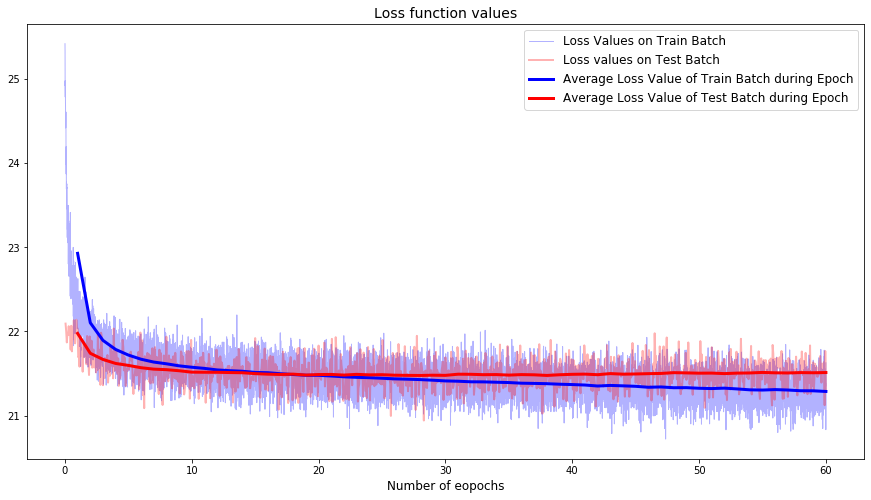

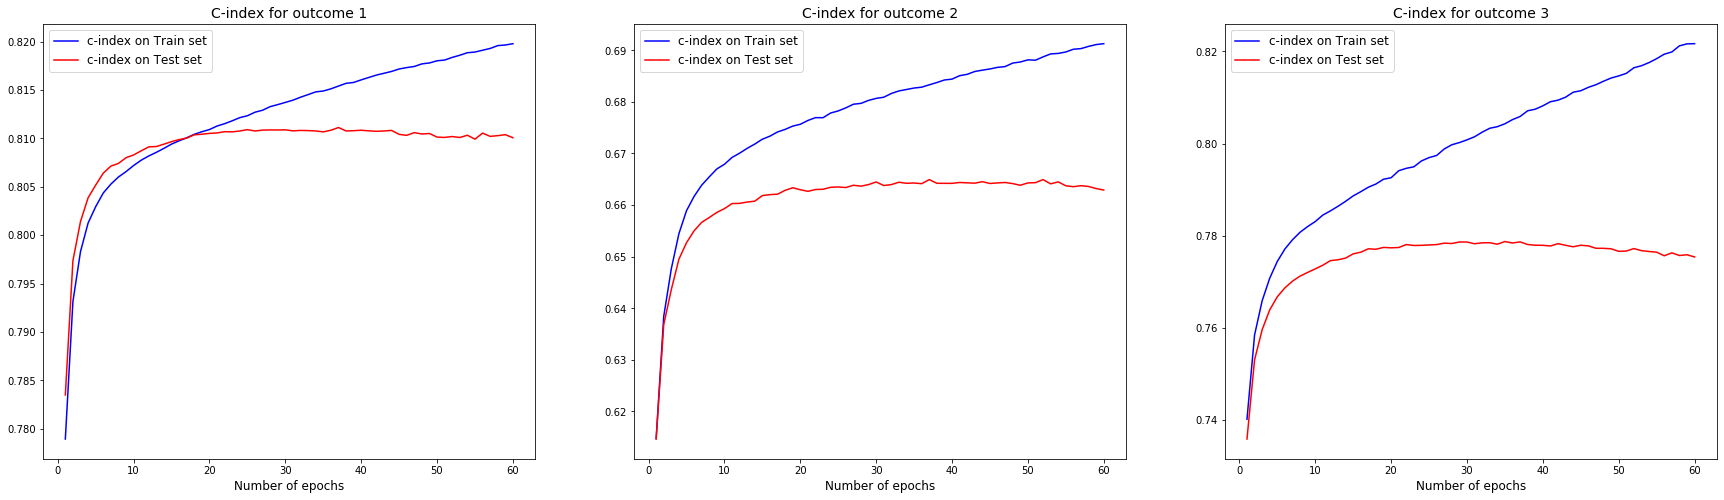

In [11]:
model_feat = all_feat
NA_feat = [feat for feat in model_feat if df[feat].isna().sum()/df.shape[0]*100 >= 10]
cat_feat = [feat for feat in model_feat if df[feat].dtypes == 'object']

RS_cvd_all = RiskScore(df,
                               features=model_feat,
                               log_features=log_feat, NA_features=NA_feat, cat_features=cat_feat,
                             test_size=0.1)

RS_cvd_all.DeepSurv(structure, resume_training=True,
            optimizer=tf.keras.optimizers.Adam(),
            n_epochs=60, lr=1e-4, batch_size=None, batch_n_events=100,
            evaluation_prms={'loss_test': True,
                             'c_test': True, 'c_train': True, 'n_bootstrap': 10,
                             'check_KM': False})

RS_cvd_all.save(filename = 'RS_cvd_all')

<lifelines.CoxPHFitter: fitted with 447699 total observations, 412084 right-censored observations>
             duration col = 'T'
                event col = 'E'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 447699
number of events observed = 35615
   partial log-likelihood = -438706.50
         time fit was run = 2021-03-31 14:57:21 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
log_HDL                         -0.03       0.97       0.00            -0.04            -0.02                 0.96                 0.98
log_LDL_MartinHopkins           -0.01       0.99       0.00            -0.02            -0.00                 0.98                 1.00
log_urate                        0.03       1.03       0.00             0.02             0.03                 1.02                 1.04
log_alkaline_phosphatase         0.03       1.03       0.00             0.02             0.04                 1.02                 1.04
log_phosphate                    0.02       1.02       0.00             0.01             0.02                 1.01                 1.02
log_vitaminD                    -0.01       0.99       0.00            -0.02            -0.01                 0.98                 0.99
log_IGF1                        -0.03       0.97       0.00            -0.04            -0.02                 0.96                 0.98
log_rheumatoid_factor            0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
log_aspartate_aminotransferase   0.01       1.01       0.00             0.01             0.02                 1.01                 1.02
log_nonHDL                      -0.01       0.99       0.00            -0.02            -0.00                 0.98                 1.00
smoking_num                      0.04       1.04       0.00             0.03             0.05                 1.03                 1.05
physical_activity_HI            -0.00       1.00       0.00            -0.01             0.00                 0.99                 1.00
log_oestradiol                  -0.06       0.94       0.00            -0.06            -0.05                 0.94                 0.95
log_cystatinC                    0.08       1.08       0.00             0.07             0.09                 1.08                 1.09
BMI_HI                           0.01       1.01       0.00             0.00             0.02                 1.00                 1.02
log_CRP                          0.04       1.04       0.00             0.03             0.04                 1.03                 1.04
log_ApoA                        -0.03       0.97       0.00            -0.04            -0.02                 0.96                 0.98
log_triglycerides                0.02       1.03       0.00             0.02             0.03                 1.02                 1.03
log_gamma_glutamyltransferase    0.05       1.05       0.00             0.04             0.05                 1.04                 1.05
log_testosterone                 0.06       1.06       0.00             0.05             0.06                 1.05                 1.07
log_ApoB_ApoA_ratio              0.03       1.03       0.00             0.02             0.04                 1.02                 1.04
log_calcium                     -0.00       1.00       0.00            -0.01             0.00                 0.99                 1.00
HLI                              0.02       1.02       0.00             0.01             0.03                 1.01                 1.03
log_direct_bilirubin             0.02       1.02       0.00             0.01             0.02                 1.01                 1.02
log_SHBG                         0.0

C-index (train) : 0.7975 (0.0011) CI(0.7960, 0.7991)
C-index (test)  : 0.8028 (0.0037) CI(0.7965, 0.8077)


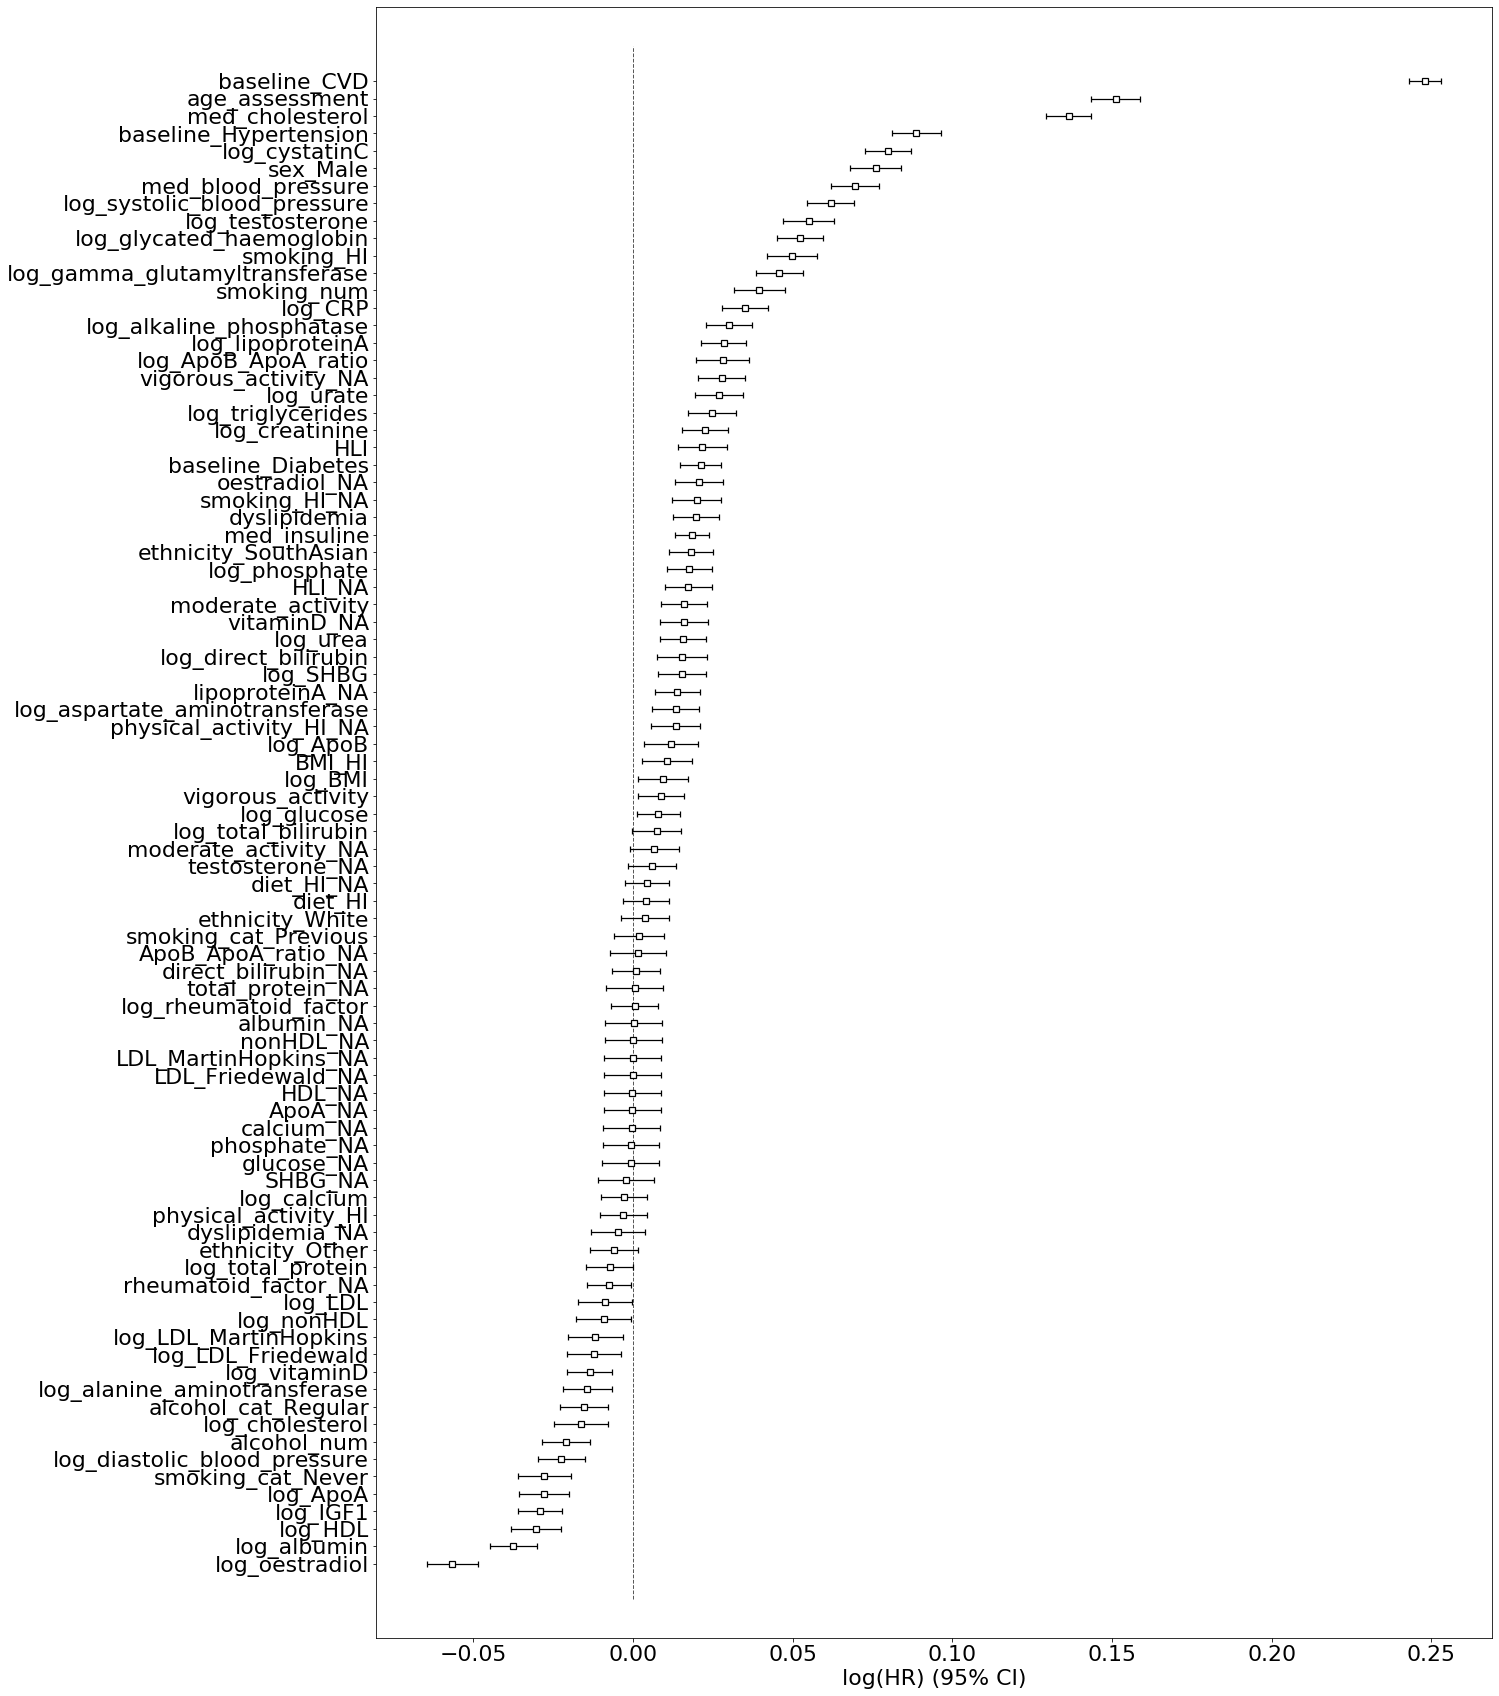

In [12]:
###RS_cvd_all

sub_dataset_all = RS_cvd_all.X_train.assign(T=RS_cvd_all.T_train, E=RS_cvd_all.E_train)
sub_dataset_all

sub_coxph_all = CoxPHFitter(penalizer = 0.1)
sub_coxph_all.fit(sub_dataset_all, duration_col='T', event_col='E')
sub_coxph_all.print_summary()

c_index_train, c_train_sample, c_train_sigma2, c_train_lower, c_train_upper = c_index_bootstrap(RS_cvd_all.T_train, RS_cvd_all.E_train, sub_coxph_all.predict_partial_hazard(RS_cvd_all.X_train).values.flatten())
c_index_test, c_test_sample, c_test_sigma2, c_test_lower, c_test_upper = c_index_bootstrap(RS_cvd_all.T_test, RS_cvd_all.E_test, sub_coxph_all.predict_partial_hazard(RS_cvd_all.X_test).values.flatten())
c_index_string = ('C-index (train) : {:.4f} ({:.4f}) CI({:.4f}, {:.4f})\n'
                  'C-index (test)  : {:.4f} ({:.4f}) CI({:.4f}, {:.4f})'.format(c_index_train, np.sqrt(c_train_sigma2), c_train_lower, c_train_upper,
                                                                                c_index_test, np.sqrt(c_test_sigma2), c_test_lower, c_test_upper))
print(c_index_string)

plt.rcParams["figure.figsize"]=20,30
matplotlib.rcParams.update({'font.size': 22})

sub_coxph_all.plot()

In [13]:
RS_cvd_all.X_train.to_pickle('RS_cvd_all_X_TRAIN')
np.savetxt('RS_cvd_all.T_train.txt', RS_cvd_all.T_train, fmt='%d')
np.savetxt('RS_cvd_all.E_train.txt', RS_cvd_all.E_train, fmt='%d')

RS_cvd_all.X_test.to_pickle('RS_cvd_all_X_test')
np.savetxt('RS_cvd_all.T_test.txt', RS_cvd_all.T_test, fmt='%d')
np.savetxt('RS_cvd_all.E_test.txt', RS_cvd_all.E_test, fmt='%d')

In [27]:
np.savetxt('RS_cvd_all.pred_score.dsv.train.txt', RS_cvd_all.deep_surv.predict_risk(RS_cvd_all.X_train)[:,0])
np.savetxt('RS_cvd_all.pred_score.dsv.test.txt', RS_cvd_all.deep_surv.predict_risk(RS_cvd_all.X_test)[:,0])
np.savetxt('RS_cvd_all.pred_score.cox.train.txt', sub_coxph_all.predict_partial_hazard(RS_cvd_all.X_train).values.flatten())
np.savetxt('RS_cvd_all.pred_score.cox.test.txt', sub_coxph_all.predict_partial_hazard(RS_cvd_all.X_test).values.flatten())

# sans baseline

[IterativeImputer] Completing matrix with shape (452293, 43)
[IterativeImputer] Ending imputation round 1/10, elapsed time 44.72
[IterativeImputer] Change: 5448.455004378889, scaled tolerance: 10.08 
[IterativeImputer] Ending imputation round 2/10, elapsed time 88.46
[IterativeImputer] Change: 1432.0320490722715, scaled tolerance: 10.08 
[IterativeImputer] Ending imputation round 3/10, elapsed time 133.94
[IterativeImputer] Change: 6185.675375416049, scaled tolerance: 10.08 
[IterativeImputer] Ending imputation round 4/10, elapsed time 177.00
[IterativeImputer] Change: 3406.464553197755, scaled tolerance: 10.08 
[IterativeImputer] Ending imputation round 5/10, elapsed time 220.83
[IterativeImputer] Change: 917.2083901631704, scaled tolerance: 10.08 
[IterativeImputer] Ending imputation round 6/10, elapsed time 265.28
[IterativeImputer] Change: 569.6764619733094, scaled tolerance: 10.08 
[IterativeImputer] Ending imputation round 7/10, elapsed time 309.81
[IterativeImputer] Change: 395.

/home/buckcenter.org/hhuang/.local/lib/python3.8/site-packages/sklearn/impute/_iterative.py:669: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


[IterativeImputer] Completing matrix with shape (452293, 43)
[IterativeImputer] Ending imputation round 1/10, elapsed time 4.29
[IterativeImputer] Ending imputation round 2/10, elapsed time 8.67
[IterativeImputer] Ending imputation round 3/10, elapsed time 13.02
[IterativeImputer] Ending imputation round 4/10, elapsed time 17.34
[IterativeImputer] Ending imputation round 5/10, elapsed time 21.71
[IterativeImputer] Ending imputation round 6/10, elapsed time 26.08
[IterativeImputer] Ending imputation round 7/10, elapsed time 30.48
[IterativeImputer] Ending imputation round 8/10, elapsed time 34.87
[IterativeImputer] Ending imputation round 9/10, elapsed time 39.25
[IterativeImputer] Ending imputation round 10/10, elapsed time 43.61
[IterativeImputer] Completing matrix with shape (50255, 43)
[IterativeImputer] Ending imputation round 1/10, elapsed time 0.25
[IterativeImputer] Ending imputation round 2/10, elapsed time 0.47
[IterativeImputer] Ending imputation round 3/10, elapsed time 0.70

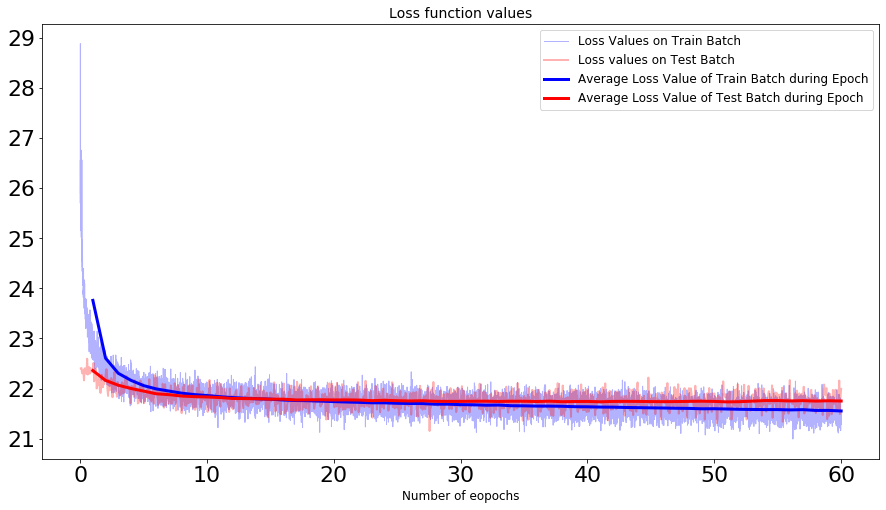

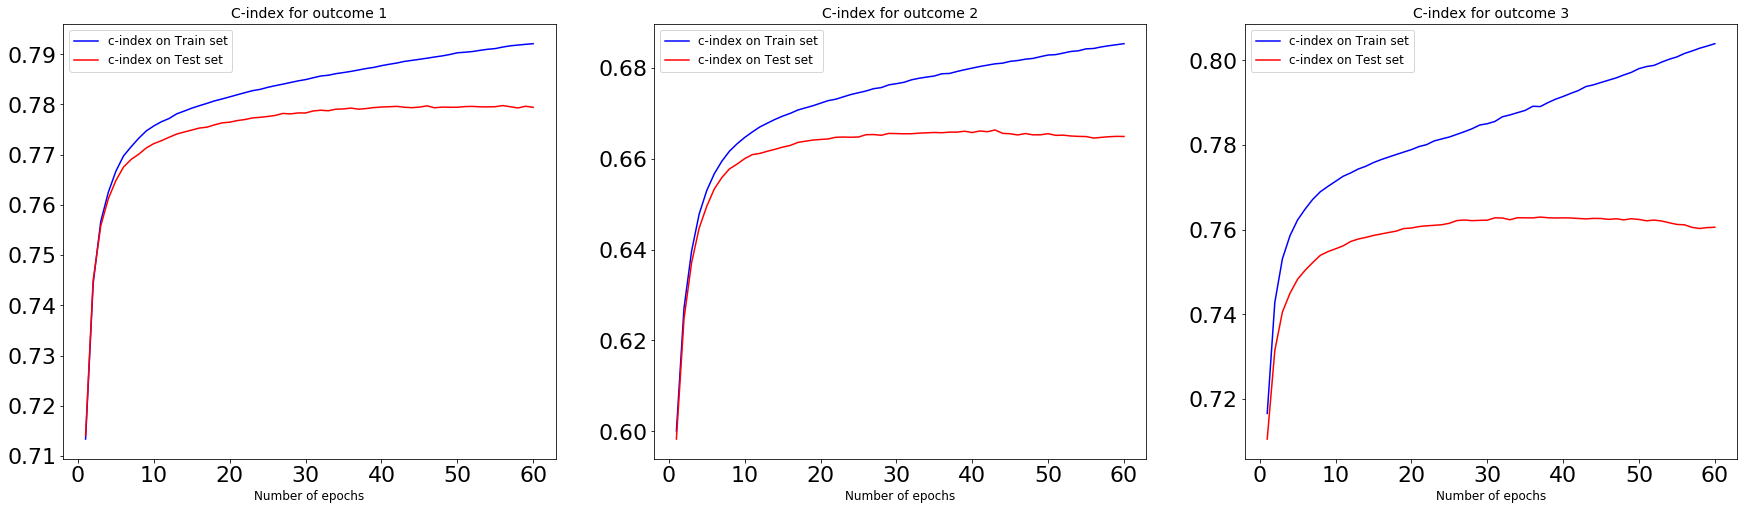

In [14]:
model_feat = lab_feat + risk_factors + HI_feat 
NA_feat = [feat for feat in model_feat if df[feat].isna().sum()/df.shape[0]*100 >= 10]
cat_feat = [feat for feat in model_feat if df[feat].dtypes == 'object']

RS_cvd_sans_base = RiskScore(df,
                               features=model_feat,
                               log_features=log_feat, NA_features=NA_feat, cat_features=cat_feat,
                             test_size=0.1)

RS_cvd_sans_base.DeepSurv(structure, resume_training=True,
            optimizer=tf.keras.optimizers.Adam(),
            n_epochs=60, lr=1e-4, batch_size=None, batch_n_events=100,
            evaluation_prms={'loss_test': True,
                             'c_test': True, 'c_train': True, 'n_bootstrap': 10,
                             'check_KM': False})

RS_cvd_sans_base.save(filename = 'RS_cvd_sans_base')

<lifelines.CoxPHFitter: fitted with 449779 total observations, 413775 right-censored observations>
             duration col = 'T'
                event col = 'E'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 449779
number of events observed = 36004
   partial log-likelihood = -451606.22
         time fit was run = 2021-03-31 15:45:34 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
log_alanine_aminotransferase    -0.01       0.99       0.00            -0.02            -0.00                 0.98                 1.00
log_albumin                     -0.03       0.97       0.00            -0.04            -0.03                 0.96                 0.97
log_alkaline_phosphatase         0.03       1.03       0.00             0.03             0.04                 1.03                 1.04
log_ApoA                        -0.04       0.96       0.00            -0.05            -0.03                 0.96                 0.97
log_ApoB                        -0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
log_aspartate_aminotransferase   0.02       1.02       0.00             0.01             0.03                 1.01                 1.03
log_CRP                          0.04       1.04       0.00             0.03             0.05                 1.03                 1.05
log_calcium                      0.01       1.01       0.00            -0.00             0.01                 1.00                 1.01
log_cholesterol                 -0.05       0.95       0.00            -0.06            -0.04                 0.94                 0.96
log_creatinine                   0.03       1.03       0.00             0.03             0.04                 1.03                 1.04
log_cystatinC                    0.11       1.12       0.00             0.11             0.12                 1.11                 1.13
log_direct_bilirubin             0.02       1.02       0.00             0.01             0.03                 1.01                 1.03
log_gamma_glutamyltransferase    0.07       1.07       0.00             0.06             0.08                 1.06                 1.08
log_glucose                      0.02       1.02       0.00             0.02             0.03                 1.02                 1.03
log_glycated_haemoglobin         0.10       1.11       0.00             0.09             0.11                 1.10                 1.11
log_HDL                         -0.05       0.95       0.00            -0.06            -0.05                 0.94                 0.95
log_IGF1                        -0.04       0.96       0.00            -0.05            -0.03                 0.95                 0.97
log_LDL                         -0.04       0.96       0.00            -0.05            -0.04                 0.95                 0.96
log_lipoproteinA                 0.04       1.04       0.00             0.03             0.05                 1.03                 1.05
log_oestradiol                  -0.07       0.94       0.00            -0.07            -0.06                 0.93                 0.94
log_phosphate                    0.02       1.03       0.00             0.02             0.03                 1.02                 1.03
log_rheumatoid_factor            0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
log_SHBG                         0.01       1.01       0.00             0.00             0.02                 1.00                 1.02
log_testosterone                 0.06       1.06       0.00             0.05             0.06                 1.05                 1.07
log_total_bilirubin              0.0

C-index (train) : 0.7606 (0.0009) CI(0.7590, 0.7618)
C-index (test)  : 0.7594 (0.0038) CI(0.7550, 0.7663)


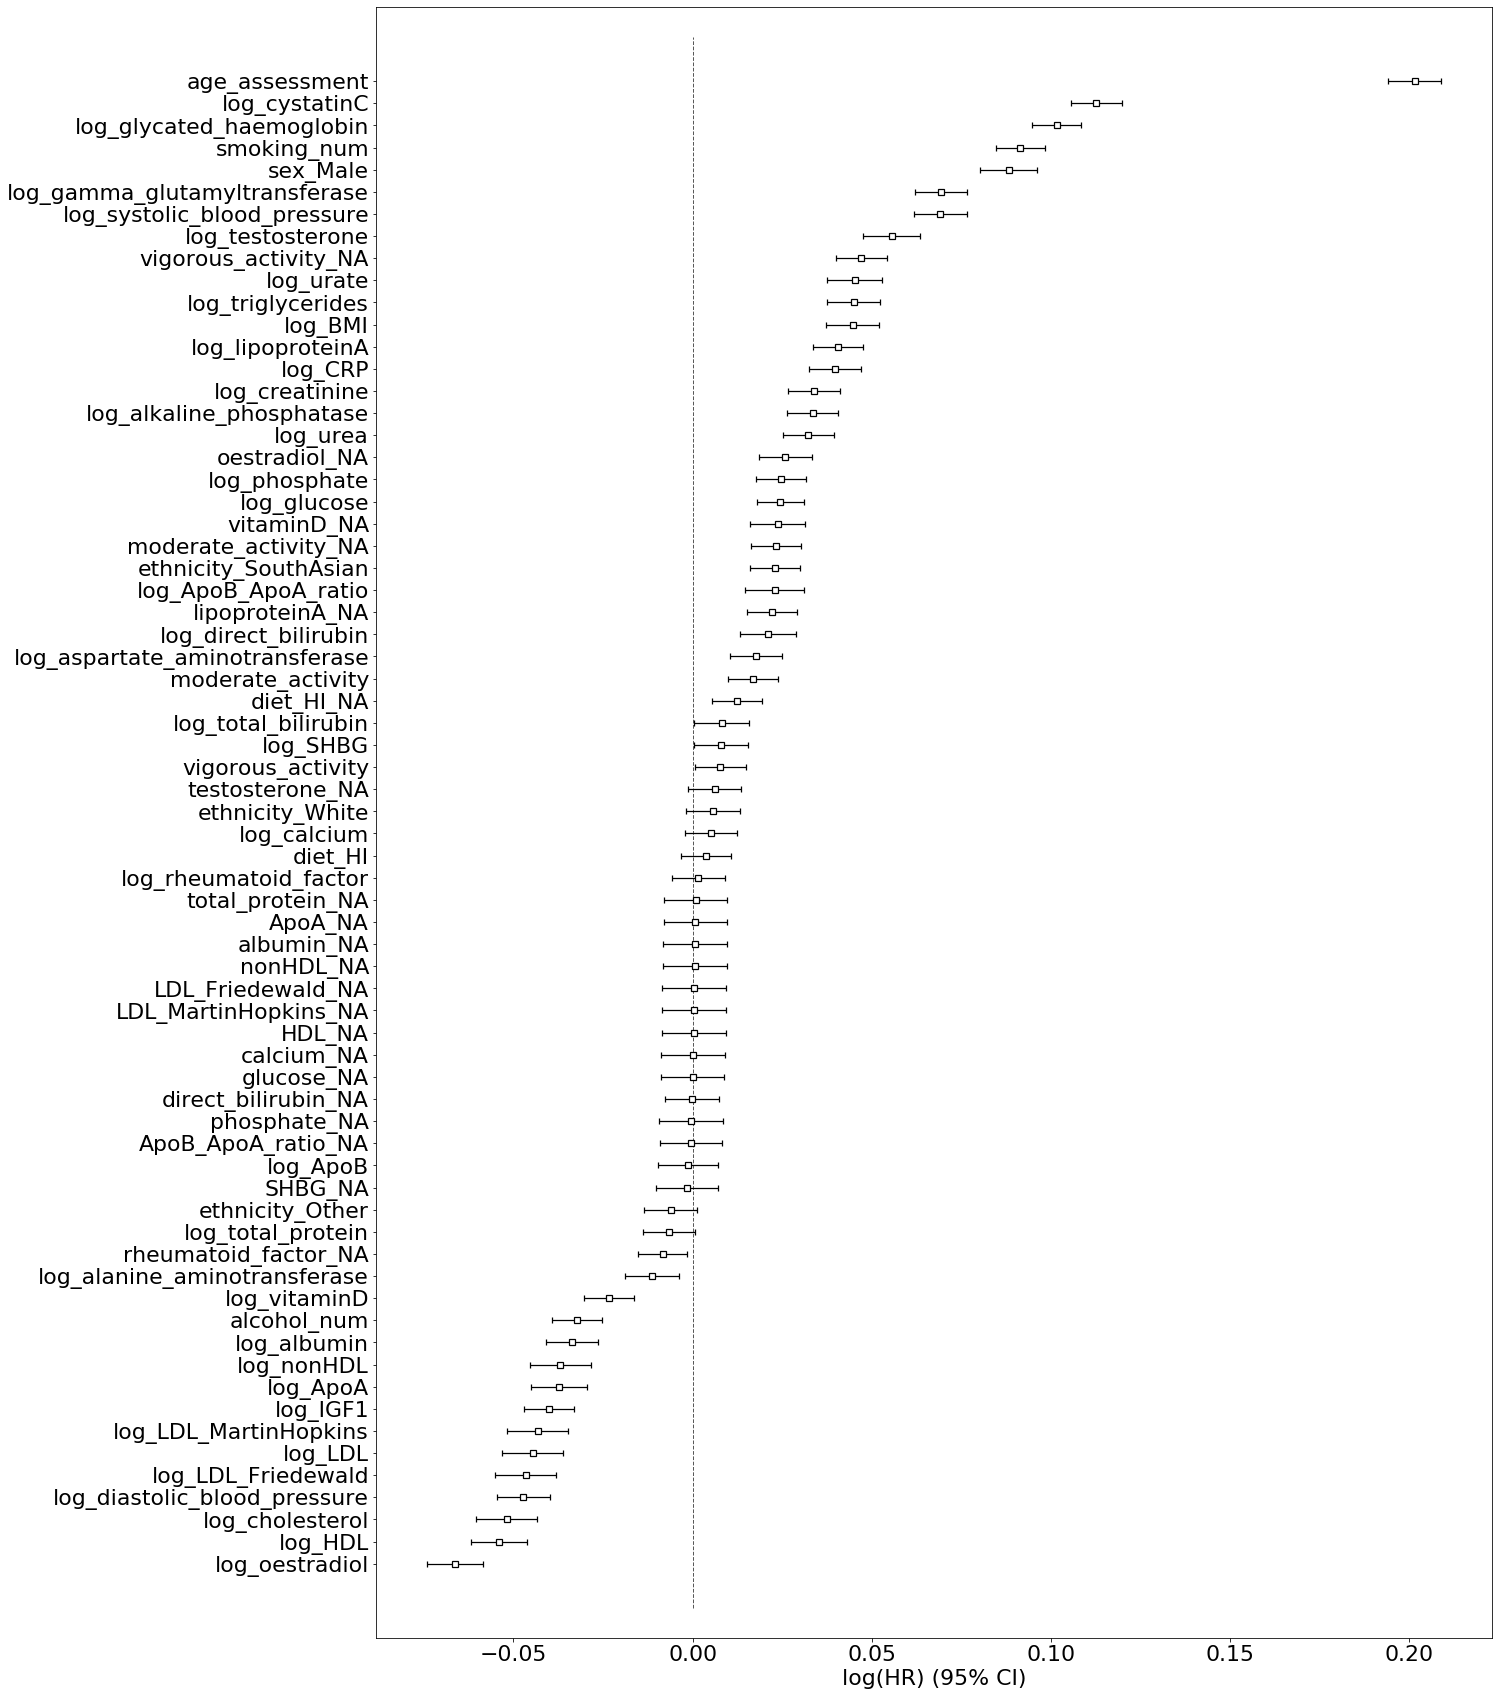

In [15]:
###RS_cvd_sans_base

sub_dataset_sans_base = RS_cvd_sans_base.X_train.assign(T=RS_cvd_sans_base.T_train, E=RS_cvd_sans_base.E_train)
sub_dataset_sans_base

sub_coxph_sans_base = CoxPHFitter(penalizer = 0.1)
sub_coxph_sans_base.fit(sub_dataset_sans_base, duration_col='T', event_col='E')
sub_coxph_sans_base.print_summary()

c_index_train, c_train_sample, c_train_sigma2, c_train_lower, c_train_upper = c_index_bootstrap(RS_cvd_sans_base.T_train, RS_cvd_sans_base.E_train, sub_coxph_sans_base.predict_partial_hazard(RS_cvd_sans_base.X_train).values.flatten())
c_index_test, c_test_sample, c_test_sigma2, c_test_lower, c_test_upper = c_index_bootstrap(RS_cvd_sans_base.T_test, RS_cvd_sans_base.E_test, sub_coxph_sans_base.predict_partial_hazard(RS_cvd_sans_base.X_test).values.flatten())
c_index_string = ('C-index (train) : {:.4f} ({:.4f}) CI({:.4f}, {:.4f})\n'
                  'C-index (test)  : {:.4f} ({:.4f}) CI({:.4f}, {:.4f})'.format(c_index_train, np.sqrt(c_train_sigma2), c_train_lower, c_train_upper,
                                                                                c_index_test, np.sqrt(c_test_sigma2), c_test_lower, c_test_upper))
print(c_index_string)

plt.rcParams["figure.figsize"]=20,30
matplotlib.rcParams.update({'font.size': 22})

sub_coxph_sans_base.plot()

In [16]:
RS_cvd_sans_base.X_train.to_pickle('RS_cvd_sans_base_X_TRAIN')
np.savetxt('RS_cvd_sans_base.T_train.txt', RS_cvd_sans_base.T_train, fmt='%d')
np.savetxt('RS_cvd_sans_base.E_train.txt', RS_cvd_sans_base.E_train, fmt='%d')

RS_cvd_sans_base.X_test.to_pickle('RS_cvd_sans_base_X_test')
np.savetxt('RS_cvd_sans_base.T_test.txt', RS_cvd_sans_base.T_test, fmt='%d')
np.savetxt('RS_cvd_sans_base.E_test.txt', RS_cvd_sans_base.E_test, fmt='%d')

In [29]:
np.savetxt('RS_cvd_sans_base.pred_score.dsv.train.txt', RS_cvd_sans_base.deep_surv.predict_risk(RS_cvd_sans_base.X_train)[:,0])
np.savetxt('RS_cvd_sans_base.pred_score.dsv.test.txt', RS_cvd_sans_base.deep_surv.predict_risk(RS_cvd_sans_base.X_test)[:,0])
np.savetxt('RS_cvd_sans_base.pred_score.cox.train.txt', sub_coxph_sans_base.predict_partial_hazard(RS_cvd_sans_base.X_train).values.flatten())
np.savetxt('RS_cvd_sans_base.pred_score.cox.test.txt', sub_coxph_sans_base.predict_partial_hazard(RS_cvd_sans_base.X_test).values.flatten())

# lab only

[IterativeImputer] Completing matrix with shape (452293, 34)
[IterativeImputer] Ending imputation round 1/10, elapsed time 27.48
[IterativeImputer] Change: 22.79965774247696, scaled tolerance: 0.00958795455192857 
[IterativeImputer] Ending imputation round 2/10, elapsed time 54.67
[IterativeImputer] Change: 6.547490050926225, scaled tolerance: 0.00958795455192857 
[IterativeImputer] Ending imputation round 3/10, elapsed time 82.16
[IterativeImputer] Change: 9.928618569024335, scaled tolerance: 0.00958795455192857 
[IterativeImputer] Ending imputation round 4/10, elapsed time 109.71
[IterativeImputer] Change: 11.295902008970497, scaled tolerance: 0.00958795455192857 
[IterativeImputer] Ending imputation round 5/10, elapsed time 138.04
[IterativeImputer] Change: 4.176652548959538, scaled tolerance: 0.00958795455192857 
[IterativeImputer] Ending imputation round 6/10, elapsed time 166.56
[IterativeImputer] Change: 1.7272962391646498, scaled tolerance: 0.00958795455192857 
[IterativeImpute

/home/buckcenter.org/hhuang/.local/lib/python3.8/site-packages/sklearn/impute/_iterative.py:669: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


[IterativeImputer] Completing matrix with shape (452293, 34)
[IterativeImputer] Ending imputation round 1/10, elapsed time 2.55
[IterativeImputer] Ending imputation round 2/10, elapsed time 5.16
[IterativeImputer] Ending imputation round 3/10, elapsed time 7.76
[IterativeImputer] Ending imputation round 4/10, elapsed time 10.37
[IterativeImputer] Ending imputation round 5/10, elapsed time 12.97
[IterativeImputer] Ending imputation round 6/10, elapsed time 15.57
[IterativeImputer] Ending imputation round 7/10, elapsed time 18.18
[IterativeImputer] Ending imputation round 8/10, elapsed time 20.78
[IterativeImputer] Ending imputation round 9/10, elapsed time 23.38
[IterativeImputer] Ending imputation round 10/10, elapsed time 25.98
[IterativeImputer] Completing matrix with shape (50255, 34)
[IterativeImputer] Ending imputation round 1/10, elapsed time 0.19
[IterativeImputer] Ending imputation round 2/10, elapsed time 0.33
[IterativeImputer] Ending imputation round 3/10, elapsed time 0.47


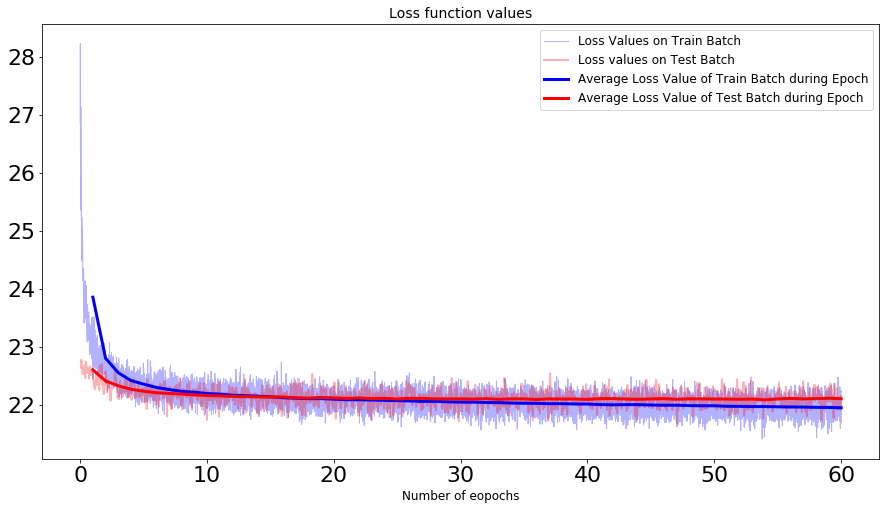

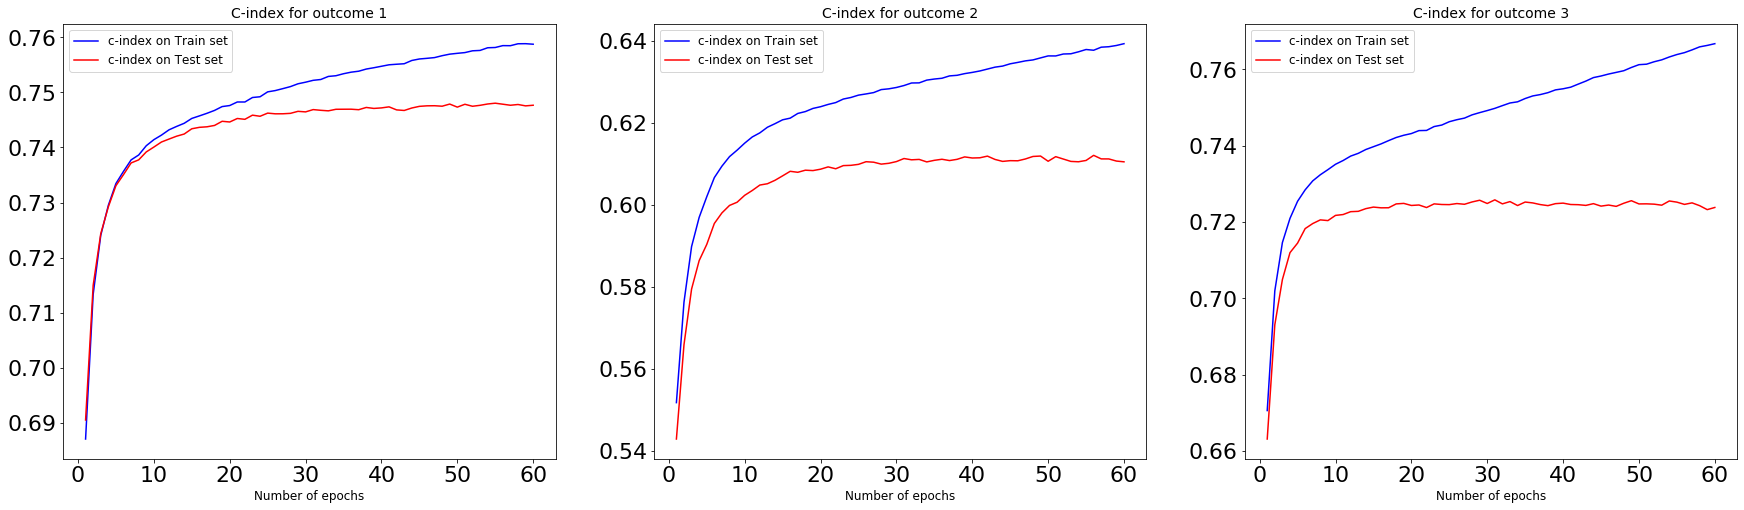

In [17]:
model_feat = lab_feat 
NA_feat = [feat for feat in model_feat if df[feat].isna().sum()/df.shape[0]*100 >= 10]
cat_feat = [feat for feat in model_feat if df[feat].dtypes == 'object']

RS_cvd_lab = RiskScore(df,
                               features=model_feat,
                               log_features=log_feat, NA_features=NA_feat, cat_features=cat_feat,
                             test_size=0.1)

RS_cvd_lab.DeepSurv(structure, resume_training=True,
            optimizer=tf.keras.optimizers.Adam(),
            n_epochs=60, lr=1e-4, batch_size=None, batch_n_events=100,
            evaluation_prms={'loss_test': True,
                             'c_test': True, 'c_train': True, 'n_bootstrap': 10,
                             'check_KM': False})

RS_cvd_lab.save(filename = 'RS_cvd_lab')

<lifelines.CoxPHFitter: fitted with 452293 total observations, 416228 right-censored observations>
             duration col = 'T'
                event col = 'E'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 452293
number of events observed = 36065
   partial log-likelihood = -455694.34
         time fit was run = 2021-03-31 16:30:23 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
log_alanine_aminotransferase    -0.01       0.99       0.00            -0.02            -0.01                 0.98                 0.99
log_albumin                     -0.04       0.96       0.00            -0.05            -0.03                 0.95                 0.97
log_alkaline_phosphatase         0.04       1.04       0.00             0.03             0.05                 1.03                 1.05
log_ApoA                        -0.04       0.96       0.00            -0.05            -0.03                 0.96                 0.97
log_ApoB                         0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
log_aspartate_aminotransferase   0.02       1.02       0.00             0.01             0.03                 1.01                 1.03
log_CRP                          0.05       1.05       0.00             0.04             0.06                 1.04                 1.06
log_calcium                      0.01       1.01       0.00            -0.00             0.01                 1.00                 1.01
log_cholesterol                 -0.06       0.94       0.00            -0.07            -0.05                 0.94                 0.95
log_creatinine                   0.04       1.04       0.00             0.03             0.04                 1.03                 1.05
log_cystatinC                    0.14       1.15       0.00             0.13             0.15                 1.14                 1.16
log_direct_bilirubin             0.02       1.02       0.00             0.02             0.03                 1.02                 1.03
log_gamma_glutamyltransferase    0.08       1.08       0.00             0.07             0.09                 1.07                 1.09
log_glucose                      0.03       1.03       0.00             0.02             0.04                 1.02                 1.04
log_glycated_haemoglobin         0.12       1.12       0.00             0.11             0.12                 1.12                 1.13
log_HDL                         -0.06       0.94       0.00            -0.07            -0.05                 0.93                 0.95
log_IGF1                        -0.06       0.95       0.00            -0.06            -0.05                 0.94                 0.95
log_LDL                         -0.05       0.95       0.00            -0.06            -0.04                 0.94                 0.96
log_lipoproteinA                 0.04       1.04       0.00             0.03             0.04                 1.03                 1.05
log_oestradiol                  -0.06       0.94       0.00            -0.07            -0.05                 0.93                 0.95
log_phosphate                    0.02       1.02       0.00             0.01             0.03                 1.01                 1.03
log_rheumatoid_factor           -0.01       0.99       0.00            -0.02            -0.00                 0.98                 1.00
log_SHBG                         0.01       1.01       0.00             0.00             0.02                 1.00                 1.02
log_testosterone                 0.08       1.08       0.00             0.07             0.09                 1.07                 1.09
log_total_bilirubin              0.0

C-index (train) : 0.7224 (0.0013) CI(0.7203, 0.7244)
C-index (test)  : 0.7232 (0.0044) CI(0.7178, 0.7315)


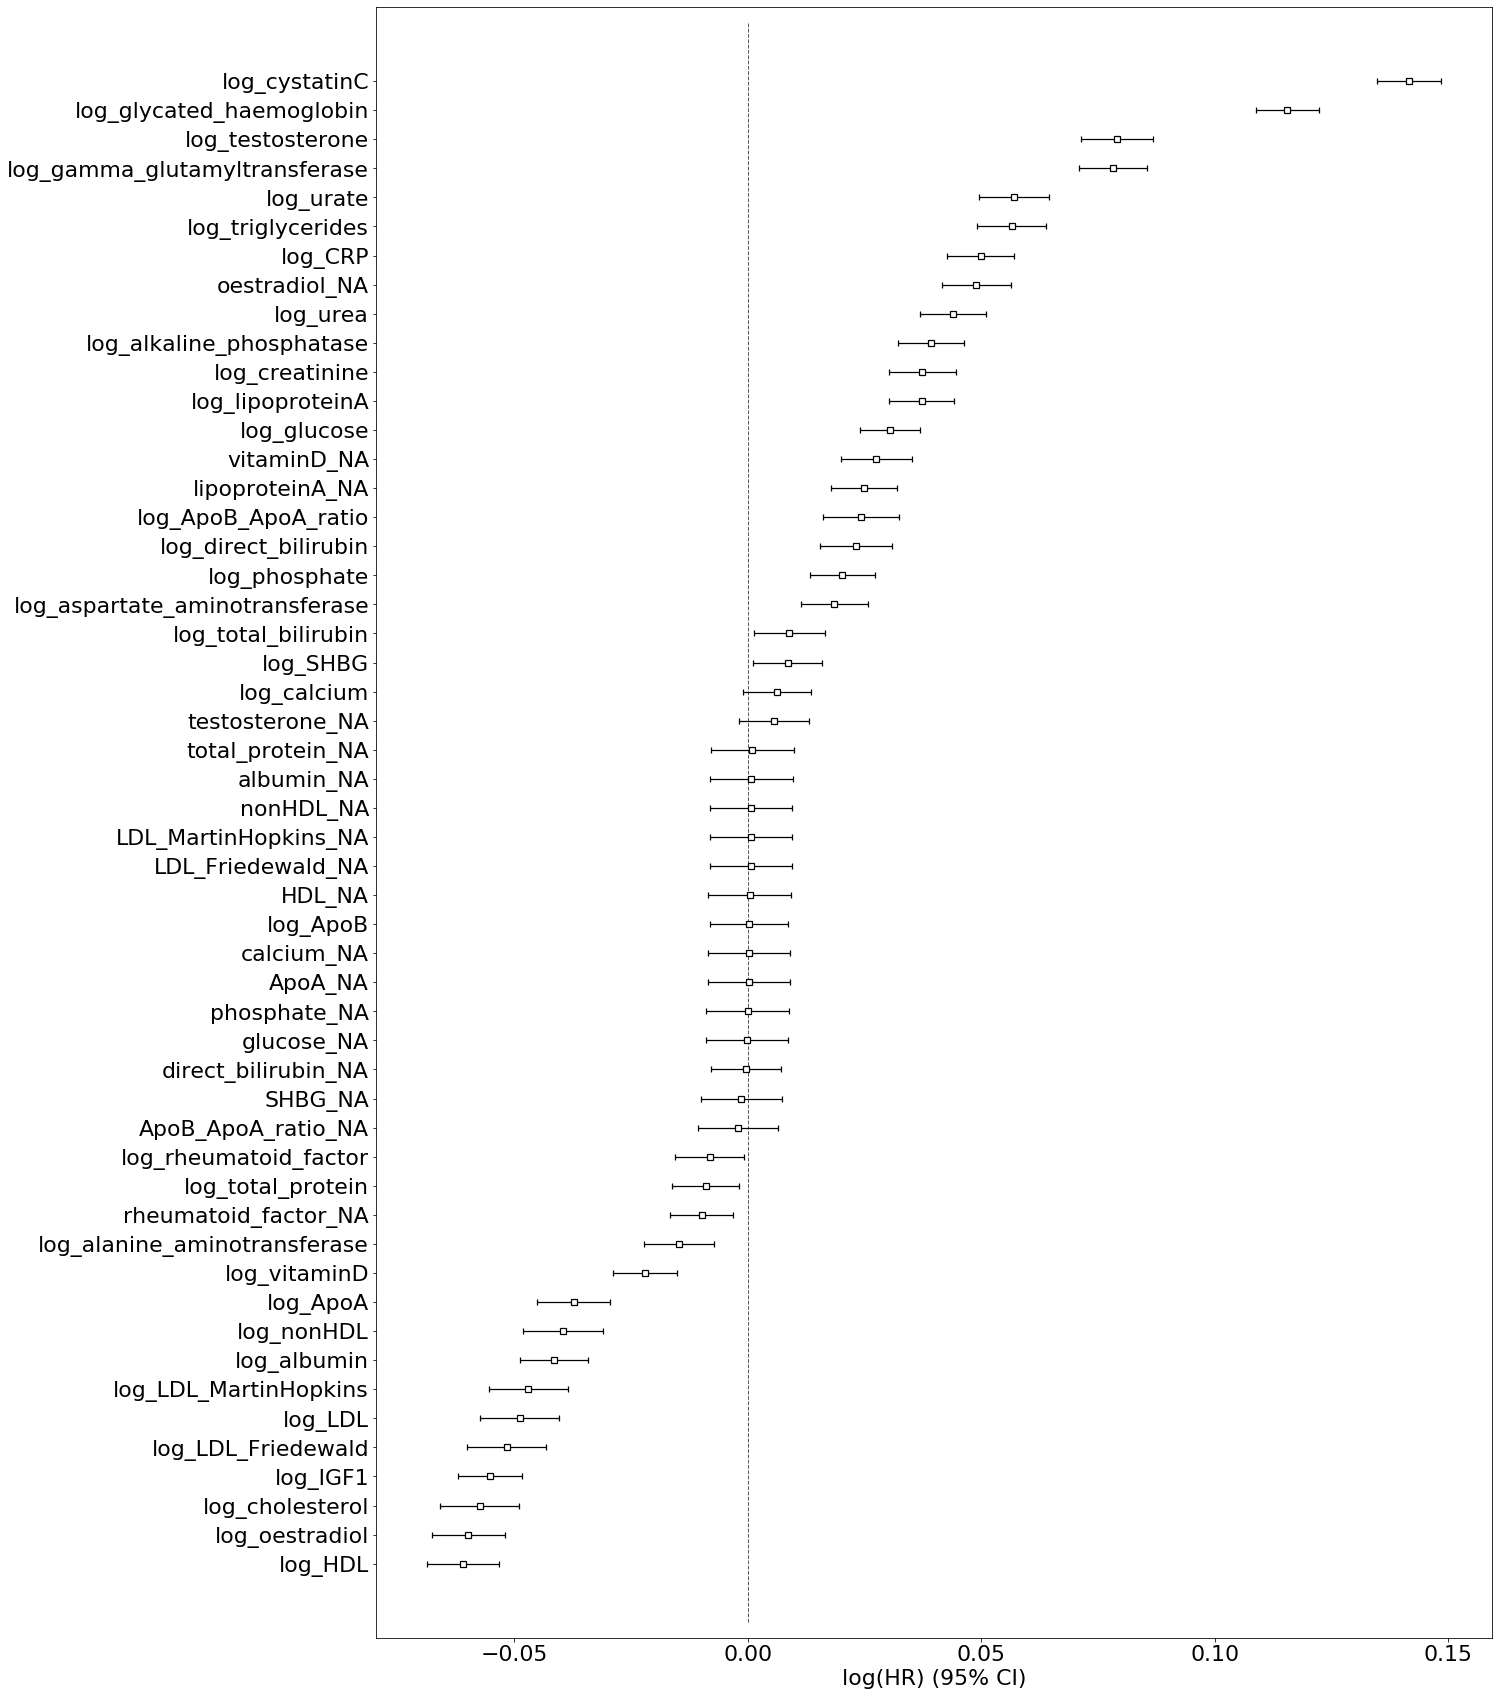

In [18]:
###RS_cvd_lab

sub_dataset_lab = RS_cvd_lab.X_train.assign(T=RS_cvd_lab.T_train, E=RS_cvd_lab.E_train)
sub_dataset_lab

sub_coxph_lab = CoxPHFitter(penalizer = 0.1)
sub_coxph_lab.fit(sub_dataset_lab, duration_col='T', event_col='E')
sub_coxph_lab.print_summary()

c_index_train, c_train_sample, c_train_sigma2, c_train_lower, c_train_upper = c_index_bootstrap(RS_cvd_lab.T_train, RS_cvd_lab.E_train, sub_coxph_lab.predict_partial_hazard(RS_cvd_lab.X_train).values.flatten())
c_index_test, c_test_sample, c_test_sigma2, c_test_lower, c_test_upper = c_index_bootstrap(RS_cvd_lab.T_test, RS_cvd_lab.E_test, sub_coxph_lab.predict_partial_hazard(RS_cvd_lab.X_test).values.flatten())
c_index_string = ('C-index (train) : {:.4f} ({:.4f}) CI({:.4f}, {:.4f})\n'
                  'C-index (test)  : {:.4f} ({:.4f}) CI({:.4f}, {:.4f})'.format(c_index_train, np.sqrt(c_train_sigma2), c_train_lower, c_train_upper,
                                                                                c_index_test, np.sqrt(c_test_sigma2), c_test_lower, c_test_upper))
print(c_index_string)

plt.rcParams["figure.figsize"]=20,30
matplotlib.rcParams.update({'font.size': 22})

sub_coxph_lab.plot()

In [19]:
RS_cvd_lab.X_train.to_pickle('RS_cvd_lab_X_TRAIN')
np.savetxt('RS_cvd_lab.T_train.txt', RS_cvd_lab.T_train, fmt='%d')
np.savetxt('RS_cvd_lab.E_train.txt', RS_cvd_lab.E_train, fmt='%d')

RS_cvd_lab.X_test.to_pickle('RS_cvd_lab_X_test')
np.savetxt('RS_cvd_lab.T_test.txt', RS_cvd_lab.T_test, fmt='%d')
np.savetxt('RS_cvd_lab.E_test.txt', RS_cvd_lab.E_test, fmt='%d')

In [30]:
np.savetxt('RS_cvd_lab.pred_score.dsv.train.txt', RS_cvd_lab.deep_surv.predict_risk(RS_cvd_lab.X_train)[:,0])
np.savetxt('RS_cvd_lab.pred_score.dsv.test.txt', RS_cvd_lab.deep_surv.predict_risk(RS_cvd_lab.X_test)[:,0])
np.savetxt('RS_cvd_lab.pred_score.cox.train.txt', sub_coxph_lab.predict_partial_hazard(RS_cvd_lab.X_train).values.flatten())
np.savetxt('RS_cvd_lab.pred_score.cox.test.txt', sub_coxph_lab.predict_partial_hazard(RS_cvd_lab.X_test).values.flatten())

# lab + demo only

[IterativeImputer] Completing matrix with shape (452293, 37)
[IterativeImputer] Ending imputation round 1/10, elapsed time 34.11
[IterativeImputer] Change: 22.20269201505143, scaled tolerance: 0.0736907670931 
[IterativeImputer] Ending imputation round 2/10, elapsed time 67.25
[IterativeImputer] Change: 6.824911499406236, scaled tolerance: 0.0736907670931 
[IterativeImputer] Ending imputation round 3/10, elapsed time 100.48
[IterativeImputer] Change: 6.405681861946253, scaled tolerance: 0.0736907670931 
[IterativeImputer] Ending imputation round 4/10, elapsed time 134.03
[IterativeImputer] Change: 12.664610191115038, scaled tolerance: 0.0736907670931 
[IterativeImputer] Ending imputation round 5/10, elapsed time 168.11
[IterativeImputer] Change: 3.4093301270445835, scaled tolerance: 0.0736907670931 
[IterativeImputer] Ending imputation round 6/10, elapsed time 207.76
[IterativeImputer] Change: 1.7050950797300684, scaled tolerance: 0.0736907670931 
[IterativeImputer] Ending imputation r

/home/buckcenter.org/hhuang/.local/lib/python3.8/site-packages/sklearn/impute/_iterative.py:669: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


[IterativeImputer] Completing matrix with shape (452293, 37)
[IterativeImputer] Ending imputation round 1/10, elapsed time 3.37
[IterativeImputer] Ending imputation round 2/10, elapsed time 6.41
[IterativeImputer] Ending imputation round 3/10, elapsed time 9.50
[IterativeImputer] Ending imputation round 4/10, elapsed time 12.99
[IterativeImputer] Ending imputation round 5/10, elapsed time 16.53
[IterativeImputer] Ending imputation round 6/10, elapsed time 20.10
[IterativeImputer] Ending imputation round 7/10, elapsed time 23.46
[IterativeImputer] Ending imputation round 8/10, elapsed time 26.78
[IterativeImputer] Ending imputation round 9/10, elapsed time 30.12
[IterativeImputer] Ending imputation round 10/10, elapsed time 33.50
[IterativeImputer] Completing matrix with shape (50255, 37)
[IterativeImputer] Ending imputation round 1/10, elapsed time 0.18
[IterativeImputer] Ending imputation round 2/10, elapsed time 0.35
[IterativeImputer] Ending imputation round 3/10, elapsed time 0.50


Epoch 34/60:Train set c_index: (0.780633 0.676776 0.781161 ) -- Test set c_index: (0.776837 0.666346 0.765841 ) -- time elapse for current epoch 0:00:35.890487
Epoch 35/60:Train set c_index: (0.780753 0.677205 0.781574 ) -- Test set c_index: (0.776803 0.667445 0.765134 ) -- time elapse for current epoch 0:00:35.197139
Epoch 36/60:Train set c_index: (0.781183 0.677589 0.782407 ) -- Test set c_index: (0.776980 0.667195 0.764986 ) -- time elapse for current epoch 0:00:35.413588
Epoch 37/60:Train set c_index: (0.781277 0.677878 0.782945 ) -- Test set c_index: (0.777149 0.667049 0.765503 ) -- time elapse for current epoch 0:00:35.757729
Epoch 38/60:Train set c_index: (0.781546 0.678065 0.783381 ) -- Test set c_index: (0.776817 0.667482 0.765451 ) -- time elapse for current epoch 0:00:35.449272
Epoch 39/60:Train set c_index: (0.781705 0.677955 0.783509 ) -- Test set c_index: (0.776806 0.667744 0.764936 ) -- time elapse for current epoch 0:00:35.427147
Epoch 40/60:Train set c_index: (0.782097

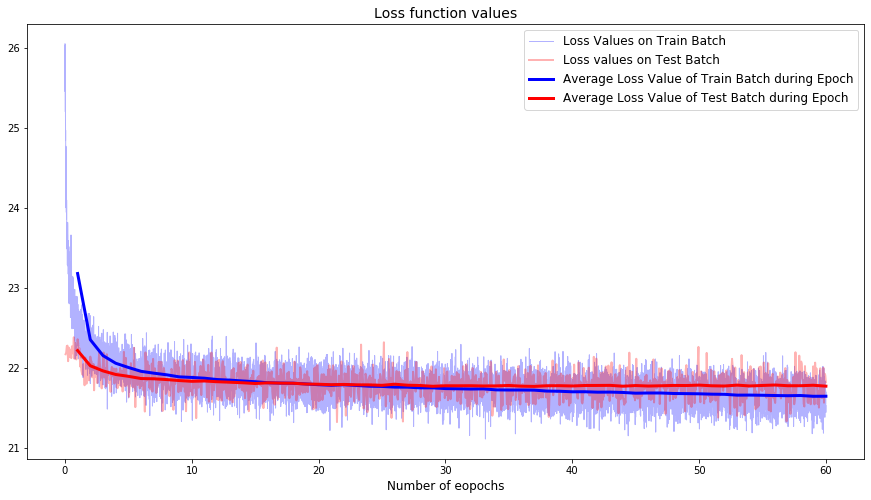

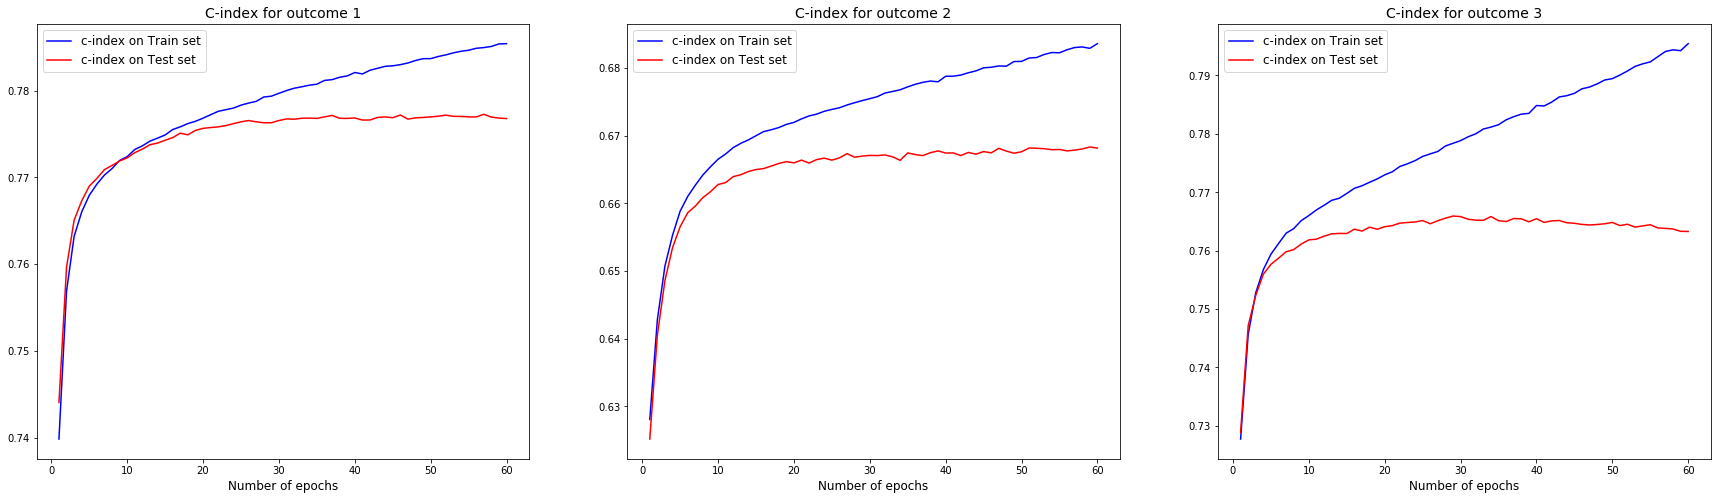

In [10]:
model_feat = lab_feat + risk_factors 

NA_feat = [feat for feat in model_feat if df[feat].isna().sum()/df.shape[0]*100 >= 10]
cat_feat = [feat for feat in model_feat if df[feat].dtypes == 'object']

RS_cvd_lab_demo = RiskScore(df,
                               features=model_feat,
                               log_features=log_feat, NA_features=NA_feat, cat_features=cat_feat,
                             test_size=0.1)

RS_cvd_lab_demo.DeepSurv(structure, resume_training=True,
            optimizer=tf.keras.optimizers.Adam(),
            n_epochs=60, lr=1e-4, batch_size=None, batch_n_events=100,
            evaluation_prms={'loss_test': True,
                             'c_test': True, 'c_train': True, 'n_bootstrap': 10,
                             'check_KM': False})

RS_cvd_lab_demo.save(filename = 'RS_cvd_lab_demo')

<lifelines.CoxPHFitter: fitted with 449799 total observations, 413902 right-censored observations>
             duration col = 'T'
                event col = 'E'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 449799
number of events observed = 35897
   partial log-likelihood = -450954.71
         time fit was run = 2021-04-10 22:43:17 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
log_alanine_aminotransferase    -0.01       0.99       0.00            -0.02            -0.00                 0.98                 1.00
log_albumin                     -0.04       0.96       0.00            -0.04            -0.03                 0.96                 0.97
log_alkaline_phosphatase         0.04       1.04       0.00             0.03             0.04                 1.03                 1.04
log_ApoA                        -0.04       0.96       0.00            -0.05            -0.03                 0.95                 0.97
log_ApoB                        -0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
log_aspartate_aminotransferase   0.01       1.01       0.00             0.01             0.02                 1.01                 1.02
log_CRP                          0.05       1.05       0.00             0.04             0.06                 1.04                 1.06
log_calcium                      0.01       1.01       0.00            -0.00             0.01                 1.00                 1.01
log_cholesterol                 -0.05       0.95       0.00            -0.06            -0.05                 0.94                 0.96
log_creatinine                   0.03       1.03       0.00             0.02             0.04                 1.02                 1.04
log_cystatinC                    0.12       1.13       0.00             0.12             0.13                 1.12                 1.14
log_direct_bilirubin             0.02       1.02       0.00             0.01             0.03                 1.01                 1.03
log_gamma_glutamyltransferase    0.07       1.08       0.00             0.07             0.08                 1.07                 1.08
log_glucose                      0.03       1.03       0.00             0.02             0.03                 1.02                 1.03
log_glycated_haemoglobin         0.11       1.12       0.00             0.10             0.12                 1.11                 1.12
log_HDL                         -0.06       0.94       0.00            -0.07            -0.05                 0.93                 0.95
log_IGF1                        -0.04       0.96       0.00            -0.05            -0.04                 0.95                 0.96
log_LDL                         -0.05       0.96       0.00            -0.05            -0.04                 0.95                 0.96
log_lipoproteinA                 0.04       1.04       0.00             0.03             0.05                 1.03                 1.05
log_oestradiol                  -0.07       0.94       0.00            -0.07            -0.06                 0.93                 0.94
log_phosphate                    0.03       1.03       0.00             0.02             0.03                 1.02                 1.03
log_rheumatoid_factor            0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
log_SHBG                         0.01       1.01       0.00            -0.00             0.01                 1.00                 1.01
log_testosterone                 0.06       1.06       0.00             0.05             0.06                 1.05                 1.07
log_total_bilirubin              0.0

C-index (train) : 0.7540 (0.0012) CI(0.7523, 0.7555)
C-index (test)  : 0.7589 (0.0022) CI(0.7568, 0.7634)


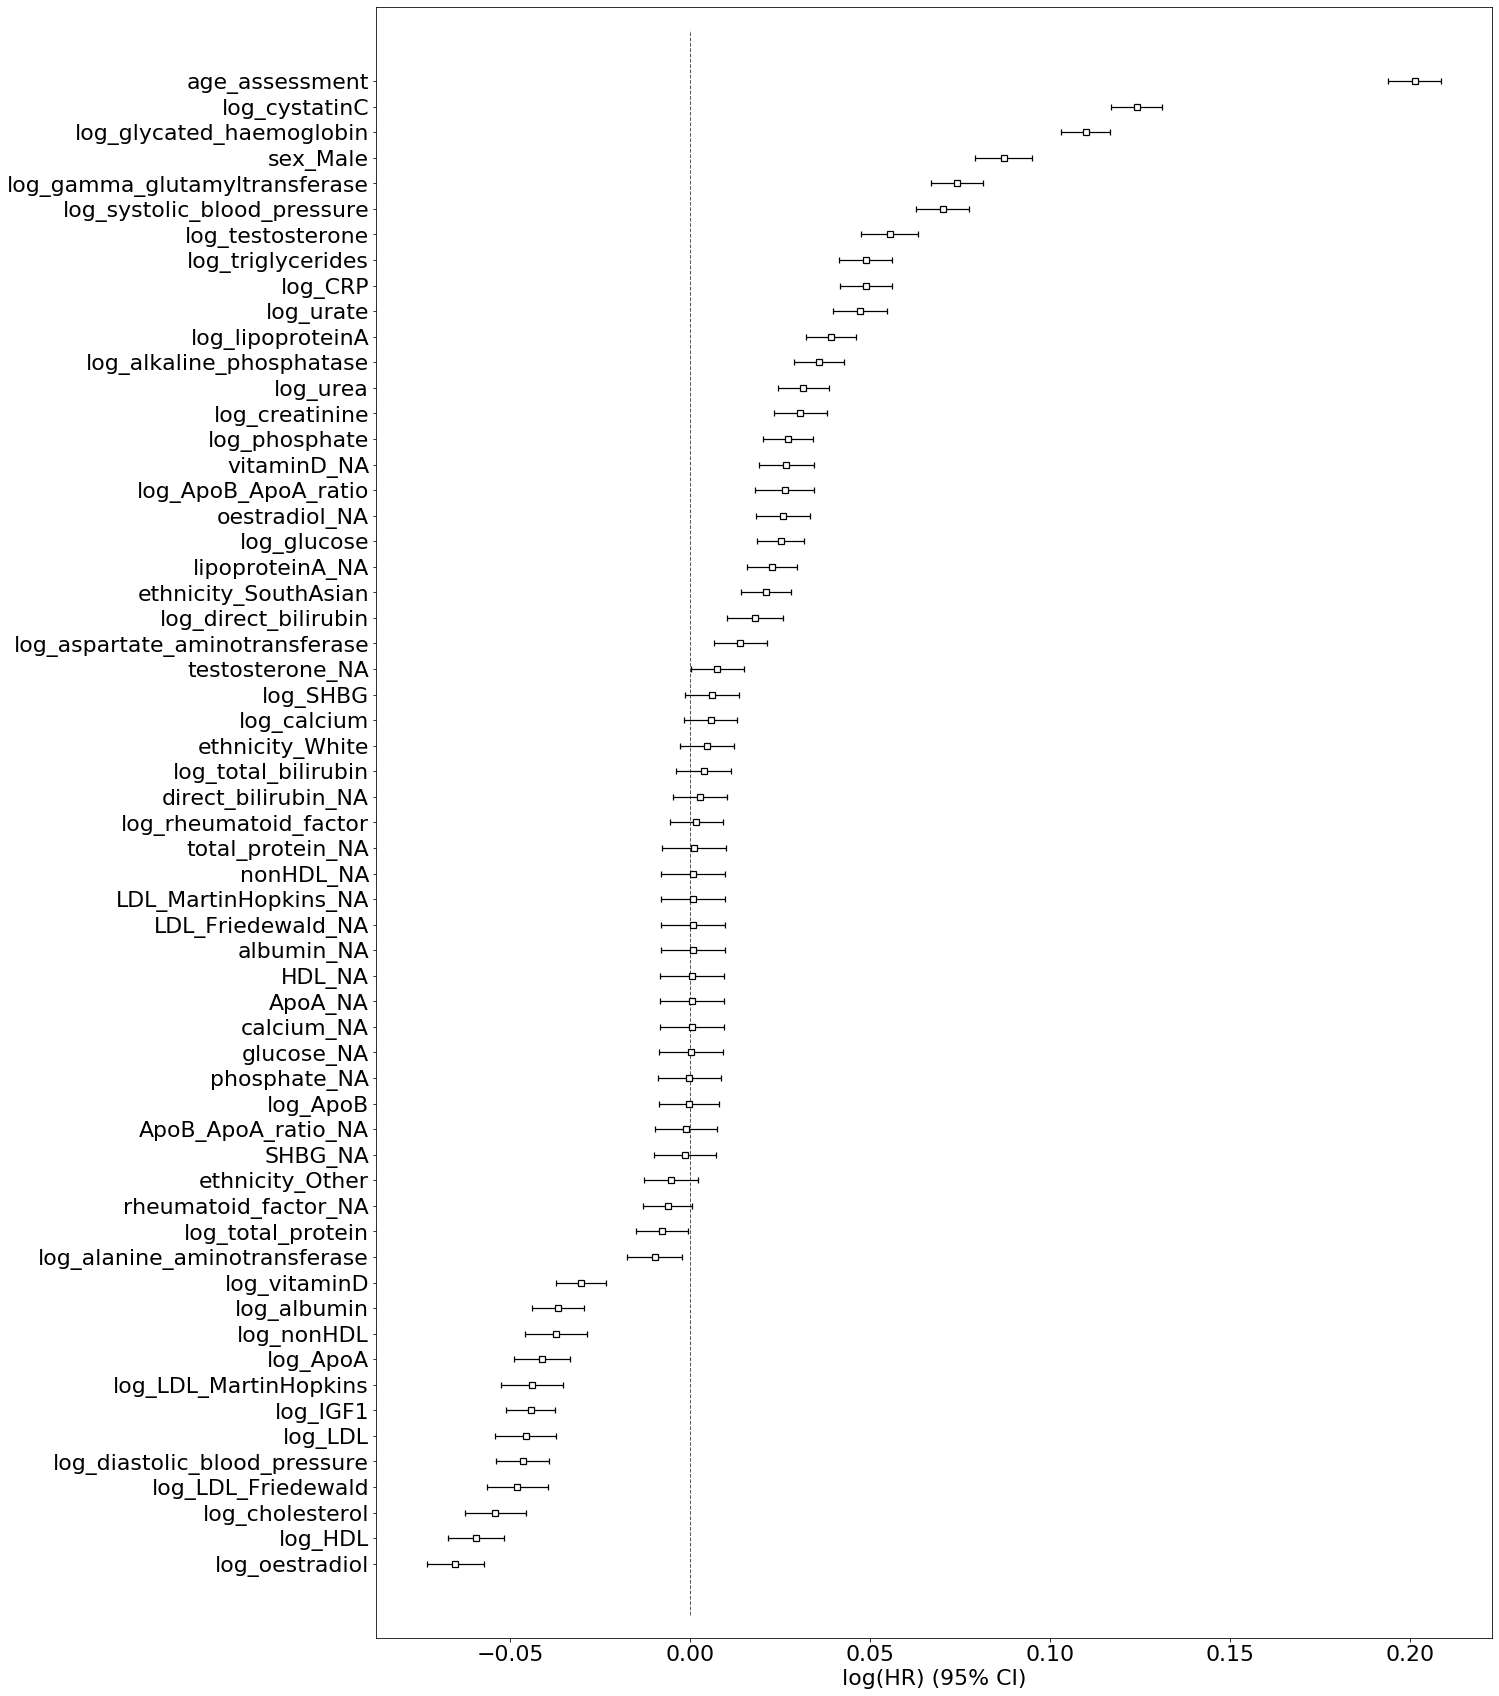

In [11]:
###RS_cvd_lab_demo

sub_dataset_lab_demo = RS_cvd_lab_demo.X_train.assign(T=RS_cvd_lab_demo.T_train, E=RS_cvd_lab_demo.E_train)
sub_dataset_lab_demo

sub_coxph_lab_demo = CoxPHFitter(penalizer = 0.1)
sub_coxph_lab_demo.fit(sub_dataset_lab_demo, duration_col='T', event_col='E')
sub_coxph_lab_demo.print_summary()

c_index_train, c_train_sample, c_train_sigma2, c_train_lower, c_train_upper = c_index_bootstrap(RS_cvd_lab_demo.T_train, RS_cvd_lab_demo.E_train, sub_coxph_lab_demo.predict_partial_hazard(RS_cvd_lab_demo.X_train).values.flatten())
c_index_test, c_test_sample, c_test_sigma2, c_test_lower, c_test_upper = c_index_bootstrap(RS_cvd_lab_demo.T_test, RS_cvd_lab_demo.E_test, sub_coxph_lab_demo.predict_partial_hazard(RS_cvd_lab_demo.X_test).values.flatten())
c_index_string = ('C-index (train) : {:.4f} ({:.4f}) CI({:.4f}, {:.4f})\n'
                  'C-index (test)  : {:.4f} ({:.4f}) CI({:.4f}, {:.4f})'.format(c_index_train, np.sqrt(c_train_sigma2), c_train_lower, c_train_upper,
                                                                                c_index_test, np.sqrt(c_test_sigma2), c_test_lower, c_test_upper))
print(c_index_string)

plt.rcParams["figure.figsize"]=20,30
matplotlib.rcParams.update({'font.size': 22})

sub_coxph_lab_demo.plot()

In [12]:
RS_cvd_lab_demo.X_train.to_pickle('RS_cvd_lab_demo_X_TRAIN')
np.savetxt('RS_cvd_lab_demo.T_train.txt', RS_cvd_lab_demo.T_train, fmt='%d')
np.savetxt('RS_cvd_lab_demo.E_train.txt', RS_cvd_lab_demo.E_train, fmt='%d')

RS_cvd_lab_demo.X_test.to_pickle('RS_cvd_lab_demo_X_test')
np.savetxt('RS_cvd_lab_demo.T_test.txt', RS_cvd_lab_demo.T_test, fmt='%d')
np.savetxt('RS_cvd_lab_demo.E_test.txt', RS_cvd_lab_demo.E_test, fmt='%d')

In [13]:
np.savetxt('RS_cvd_lab_demo.pred_score.dsv.train.txt', RS_cvd_lab_demo.deep_surv.predict_risk(RS_cvd_lab_demo.X_train)[:,0])
np.savetxt('RS_cvd_lab_demo.pred_score.dsv.test.txt', RS_cvd_lab_demo.deep_surv.predict_risk(RS_cvd_lab_demo.X_test)[:,0])
np.savetxt('RS_cvd_lab_demo.pred_score.cox.train.txt', sub_coxph_lab_demo.predict_partial_hazard(RS_cvd_lab_demo.X_train).values.flatten())
np.savetxt('RS_cvd_lab_demo.pred_score.cox.test.txt', sub_coxph_lab_demo.predict_partial_hazard(RS_cvd_lab_demo.X_test).values.flatten())